In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import neighbors
import datetime as dt
from scipy.spatial import distance as dist
sns.set_style('ticks')
%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
training = pd.read_csv("training_set.csv")
training.head()

,PeriArea,CArea,CircArea,labels
0,0.107588,0.990741,0.674301,0
1,-0.183664,-0.979766,-0.693115,1
2,0.109353,0.969764,0.681162,0
3,-0.192056,-0.962244,-0.640918,1
4,0.109963,0.968472,0.675689,0


In [3]:
n_neighbors = 2

features = ['PeriArea', 'CArea', 'CircArea']
training_set = training#.sample(5000)
X = training_set[features].values
y = training_set.iloc[:,-1].values

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance')

In [4]:
def crop(src, pt1, pt2):
    
    """ Returns a cropped version of src """
    
    cropped = src[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    
    return cropped

"""def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = 'float32')
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect"""

def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
 
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
 
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
 
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = pts
    (tl, tr, br, bl) = rect
 
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    #maxWidth = max(int(widthA), int(widthB))
 
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    #maxHeight = max(int(heightA), int(heightB))
 
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    maxSide = max(int(widthA), int(widthB), int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxSide - 1, 0],
        [maxSide - 1, maxSide - 1],
        [0, maxSide - 1]], dtype = "float32")
 
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxSide, maxSide))
 
    # return the warped image
    return warped

In [5]:
#pt1 = (1200,500)
#pt2 = (2800,1500)
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/test.mov") 
pt1 = (0,0)
pt2 = (1080,1500)
cap = cv2.VideoCapture("/Users/Jake/Google Drive/VID_20160719_103625.mp4") 
resize_f = 1
n_frames = 0
barcode_size = (30,30)
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/CLIP0000075_000.mov")
#pt1 = (1000,0)
#pt2 = (3200,2160)


# Define the codec and create VideoWriter object
#fourcc = cv2.VideoWriter_fourcc('A','V','C','1')
#out = cv2.VideoWriter('output.mp4',fourcc, 20.0, (2200,2160), True)
t0 = dt.datetime.now()
while cap.isOpened():  
#for i in range(10):
    contours_list = []
    ret, img = cap.read()
    features_list = []
    pixel_values = []
    warped_list = []
    if ret:
        cropped = crop(img, pt1, pt2)
        _, gray, _ = cv2.split(cropped)
        blurred = cv2.GaussianBlur(gray, (11,11), 1)
        #blurred = enhanced
        resized = cv2.resize(blurred, (0,0), None, fx = resize_f, fy = resize_f)
        thresh = cv2.adaptiveThreshold(resized, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 201, 51)
        contour_image, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in contours:
            
            if len(cnt) >= 5:
                
                area = cv2.contourArea(cnt, True)
                convex = cv2.convexHull(cnt)
                peri_cnt = cv2.arcLength(cnt, True)

                approx = cv2.approxPolyDP(cnt, 0.13 * peri_cnt, True)
                
                if 2000*resize_f > np.abs(area) > 200*resize_f and peri_cnt > 30*resize_f:

                    if len(approx) == 4:  
                        
                        cnt_shape = approx.shape
                        pts = approx.reshape((cnt_shape[0],cnt_shape[2]))
                        box = cv2.minAreaRect(cnt)
                        box = cv2.boxPoints(box)
                        pts = np.array(box, dtype="int")

                        pts = order_points(pts)
                        
                        warped = four_point_transform(cropped, pts/resize_f)
                        
                        
                        resize_warp = cv2.resize(warped, barcode_size, interpolation = cv2.INTER_AREA)
                        #resize_warp_hsv = cv2.cvtColor(resize_warp, cv2.COLOR_BGR2HSV)
                        #resize_warp_final = np.concatenate((resize_warp, resize_warp_hsv))
                        resize_warp = resize_warp[:,:,1]
                        warped_list.append(resize_warp)
                        resize_warp_flat = resize_warp.flatten()

                        pixel_values.append(resize_warp_flat)
                        
                        convex = cv2.convexHull(cnt)
                        convex_area = cv2.contourArea(convex)
                        carea = area/convex_area
                        peri_area = peri_cnt/area
                        
                        (x,y),radius = cv2.minEnclosingCircle(cnt)
                        circ_area = np.pi * radius**2
                        circ_area = area/circ_area
                        
                        features_list.append([peri_area, carea, circ_area])
                        contours_list.append(cnt/resize_f)
                        
        features = np.array(features_list)
        good_contours = np.array(contours_list)
        warped_list = np.array(warped_list)
        pixel_values = np.array(pixel_values)
        if len(features) > 0 and len(good_contours) > 0:
            prediction = clf.predict(features)
            good_contours = good_contours[prediction == 1]   
            warped_list = warped_list[prediction == 1]
            pixel_values = pixel_values[prediction == 1]
        if len(good_contours) > 1:
            cv2.drawContours(cropped, good_contours, -1, (255,0,0), 2)
        barcodes1 = np.concatenate(warped_list[:29]).T
        barcodes2 = np.concatenate(warped_list[30:59]).T
        barcodes3 = np.concatenate(warped_list[60:89]).T
        barcodes4 = np.concatenate(warped_list[90:119]).T
        barcodes_list = [barcodes1, barcodes2, barcodes3, barcodes4]
        if barcodes1.shape == barcodes2.shape == barcodes3.shape == barcodes4.shape:
            barcodes = np.concatenate(barcodes_list, axis = 0)
            barcodes = cv2.resize(barcodes, (0,0), None, fx = 2.5, fy = 2.5)
            cv2.imshow("barcodes", barcodes)

        #cropped = cv2.resize(cropped, (0,0), None, fx = 0.8, fy = 0.8)
        #thresh = cv2.resize(thresh, (0,0), None, fx = float(1./resize_f*0.8), fy = float(1./resize_f*0.8))
        
        #out.write(cropped)
        cv2.imshow('Video', cropped)
        #cv2.imshow("thresh", thresh)
        n_frames += 1
    else:
        break
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
cap.release()
#out.release()
cv2.destroyAllWindows()

for i in range(5):
    cv2.waitKey(1)
    
t1 = dt.datetime.now()

dtime = t1 - t0
dtime = dtime.total_seconds()
fps = n_frames/dtime
print fps

8.46032679591


In [160]:
thresh.shape

(4500, 3240)

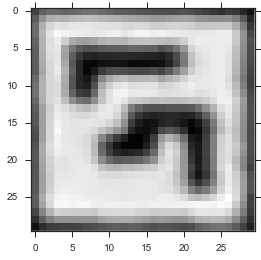

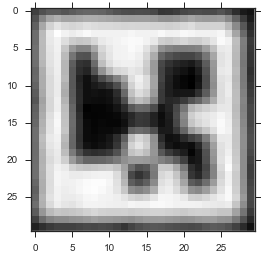

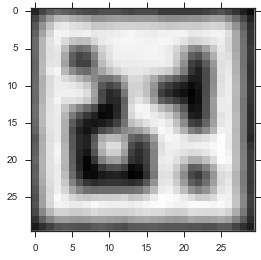

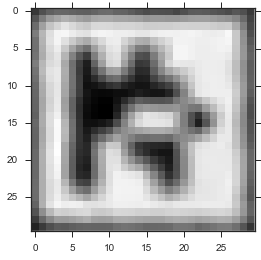

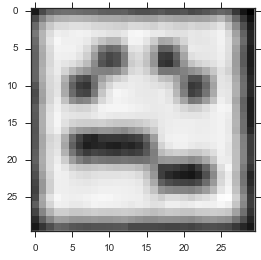

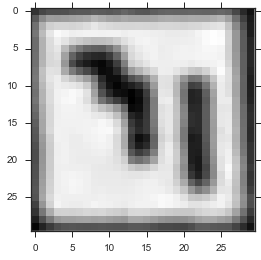

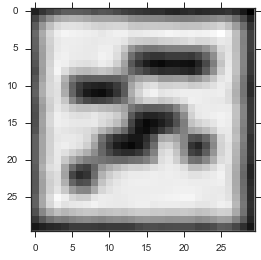

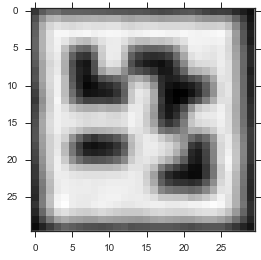

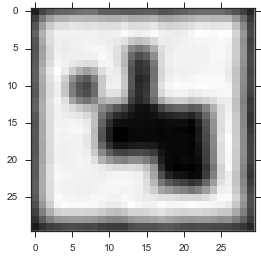

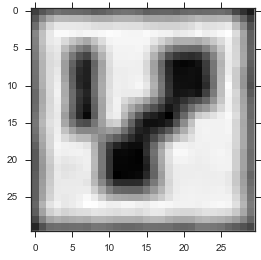

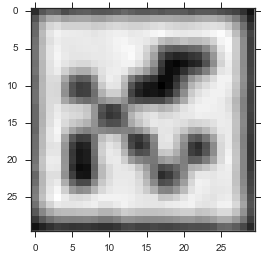

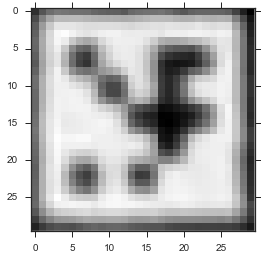

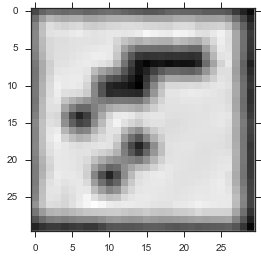

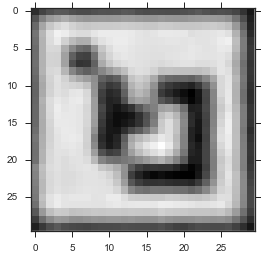

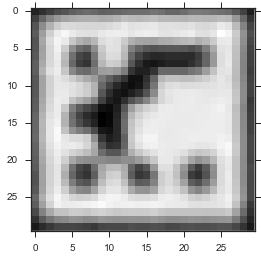

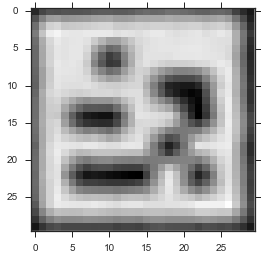

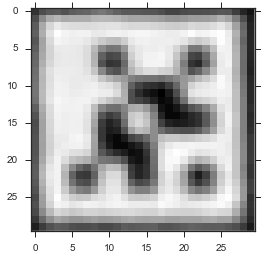

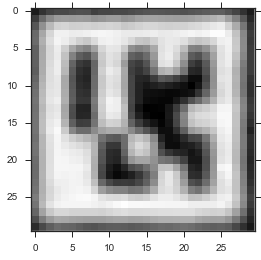

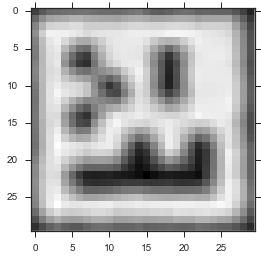

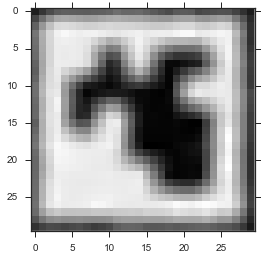

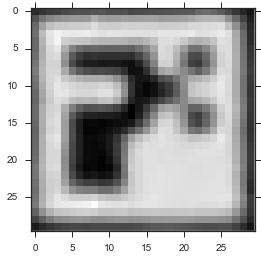

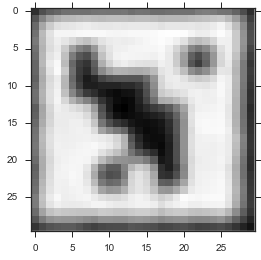

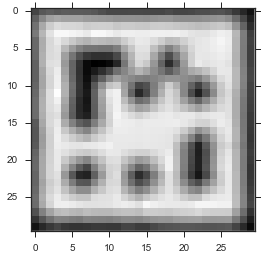

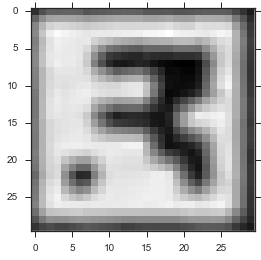

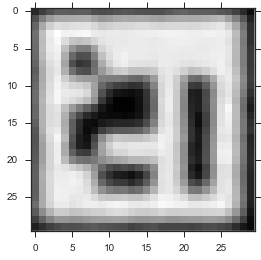

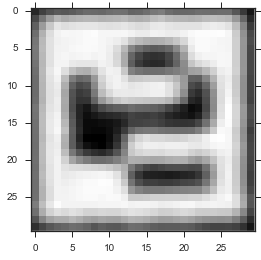

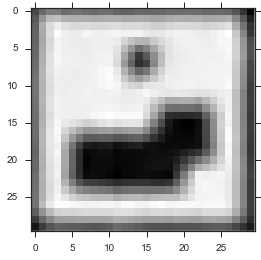

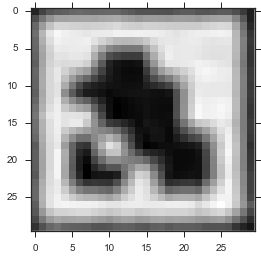

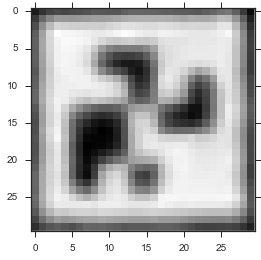

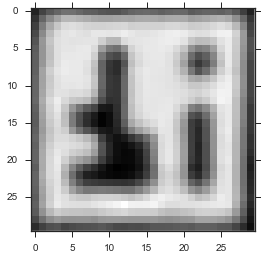

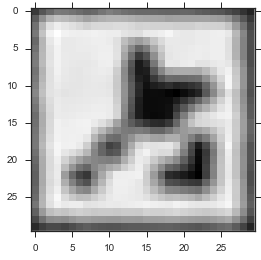

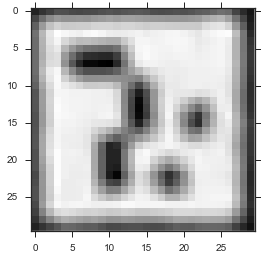

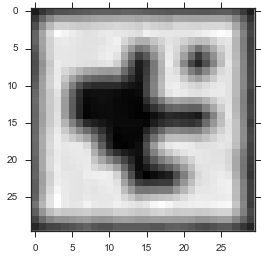

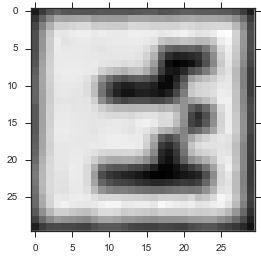

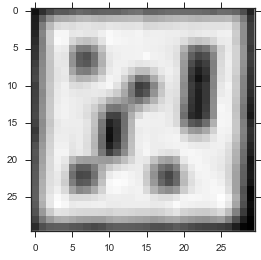

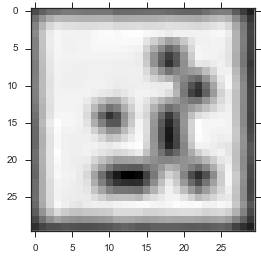

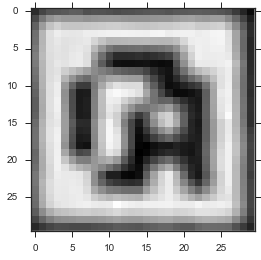

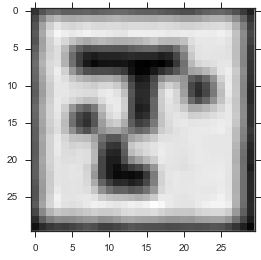

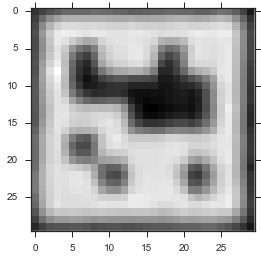

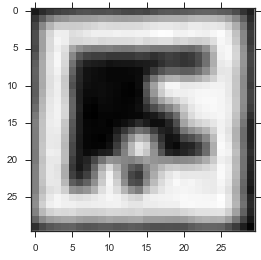

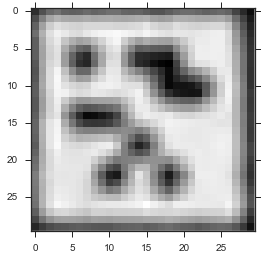

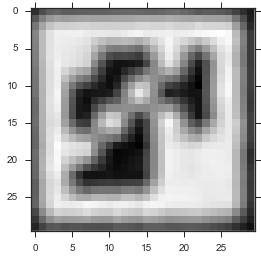

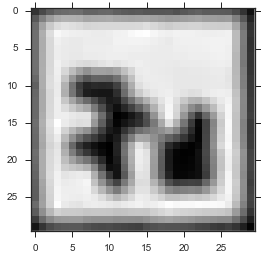

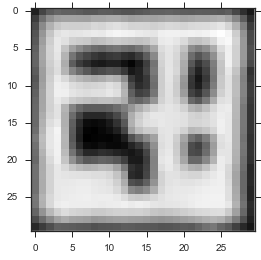

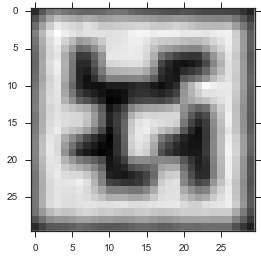

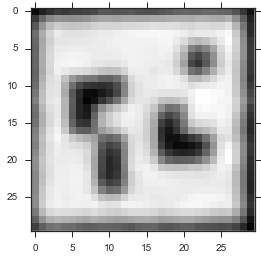

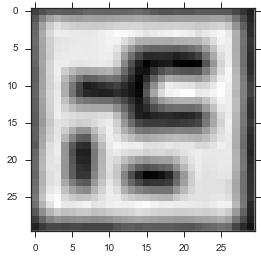

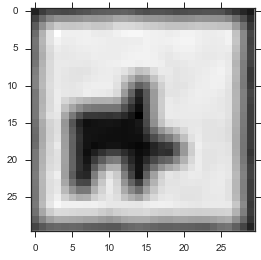

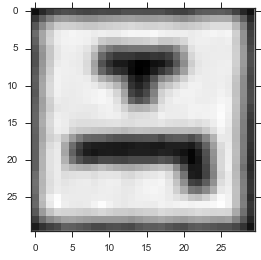

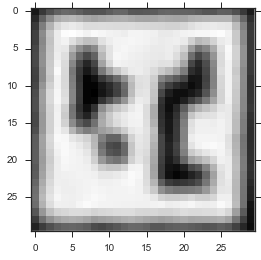

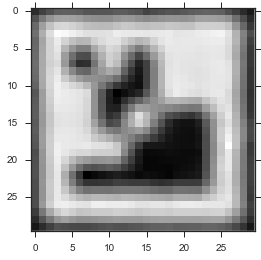

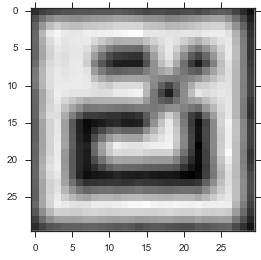

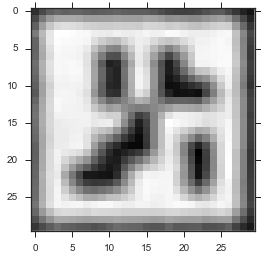

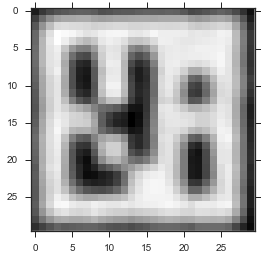

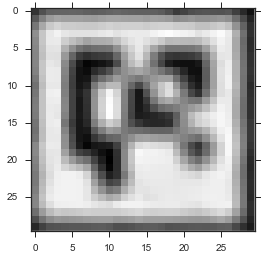

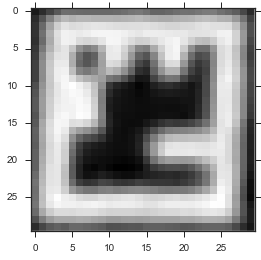

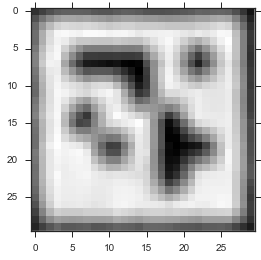

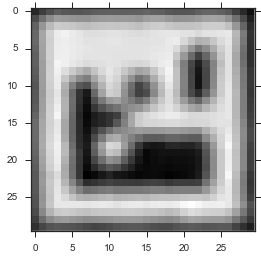

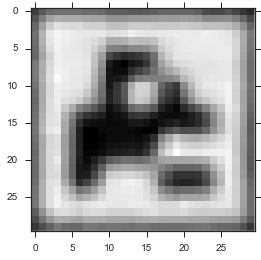

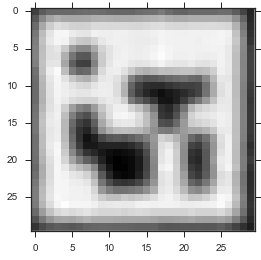

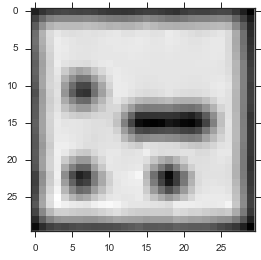

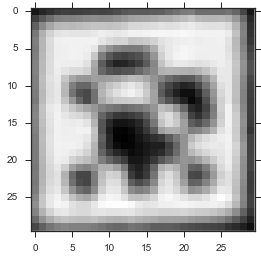

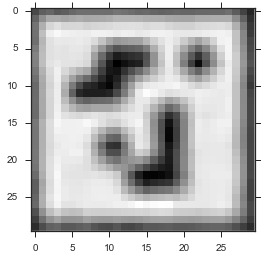

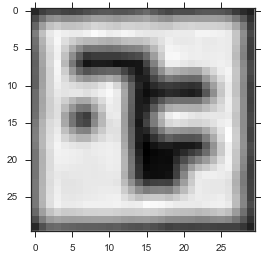

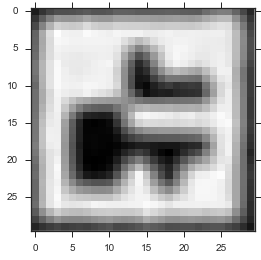

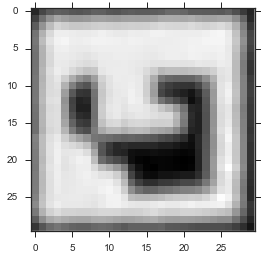

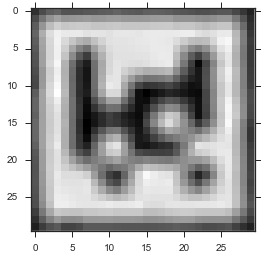

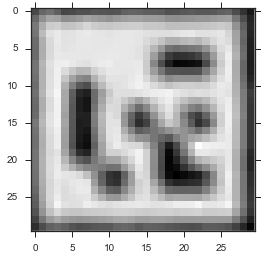

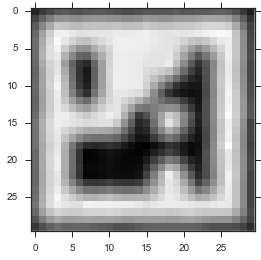

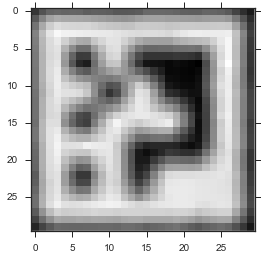

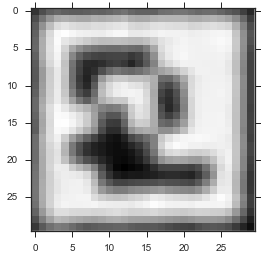

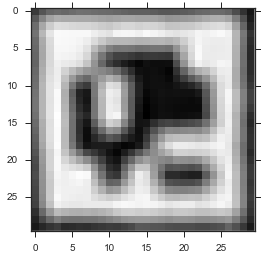

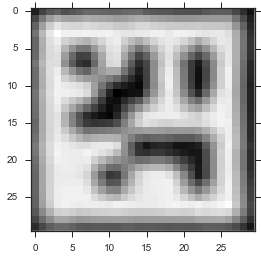

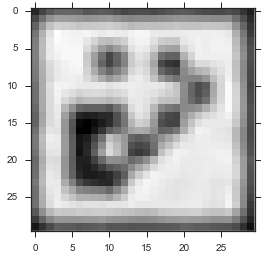

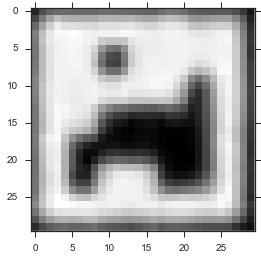

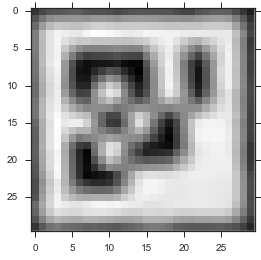

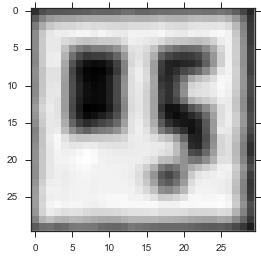

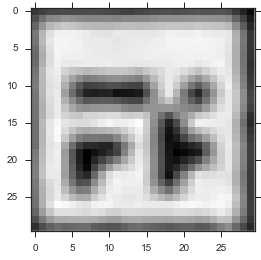

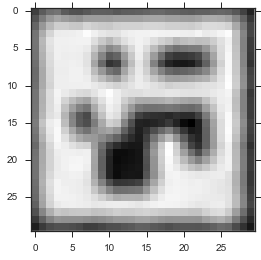

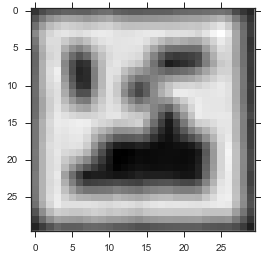

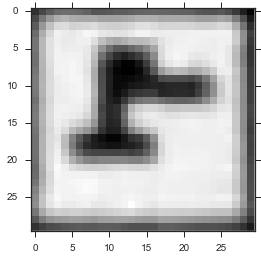

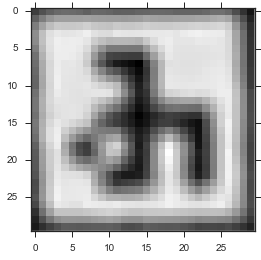

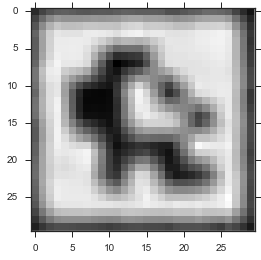

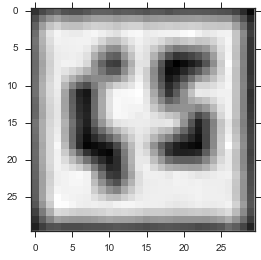

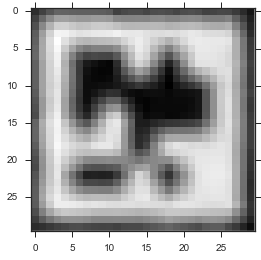

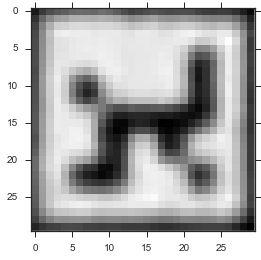

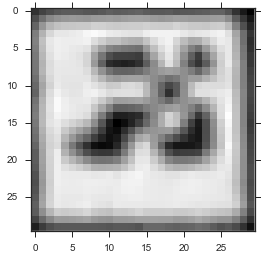

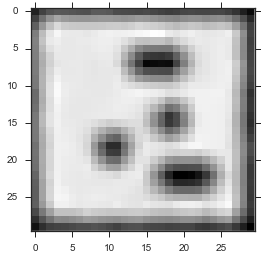

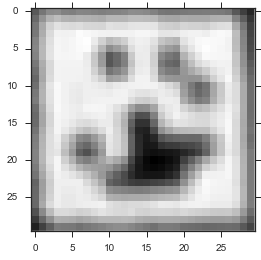

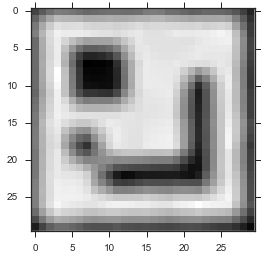

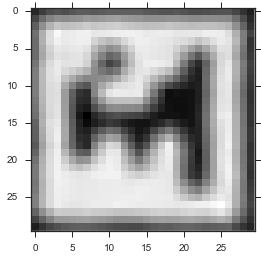

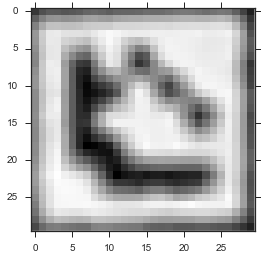

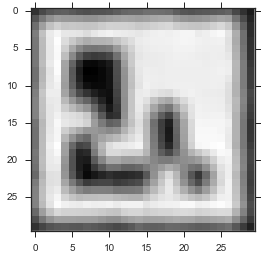

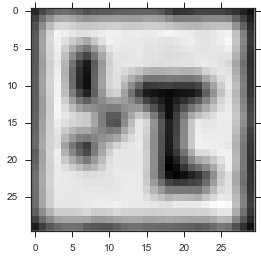

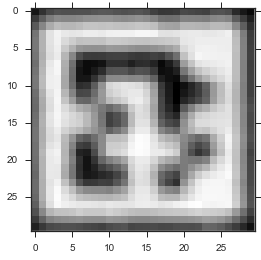

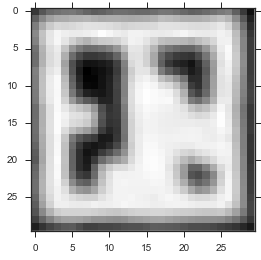

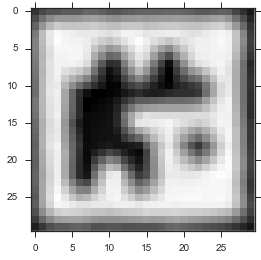

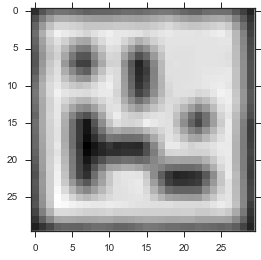

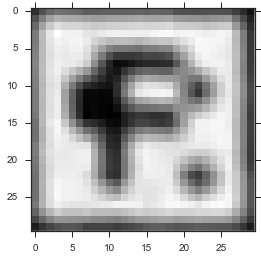

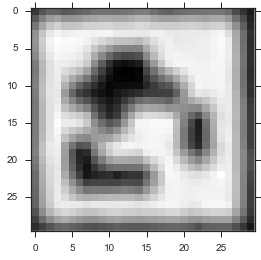

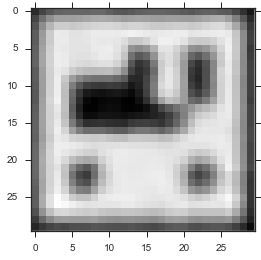

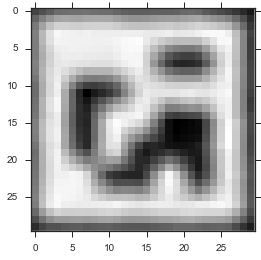

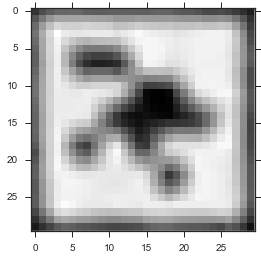

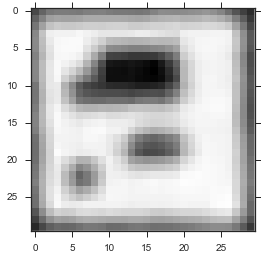

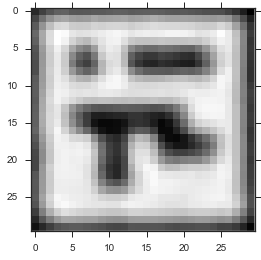

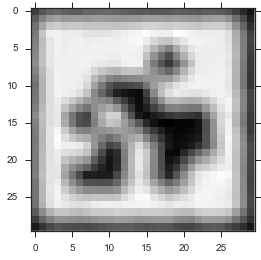

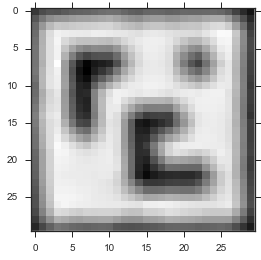

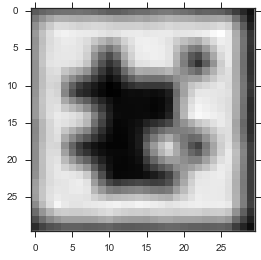

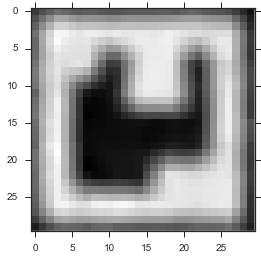

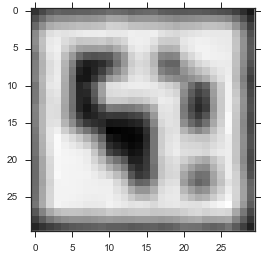

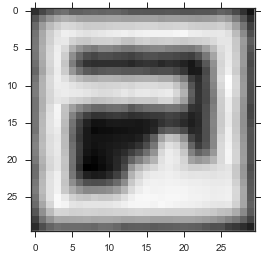

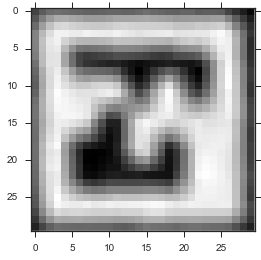

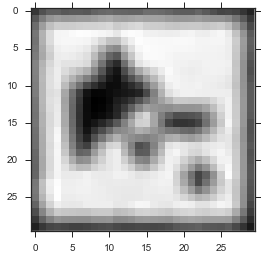

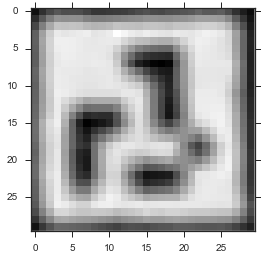

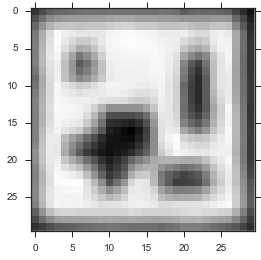

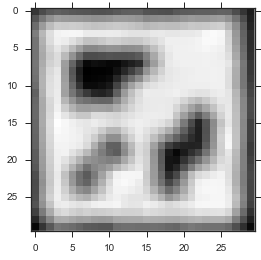

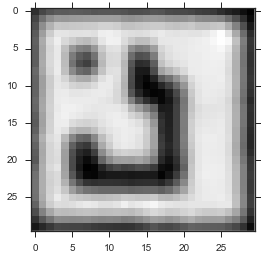

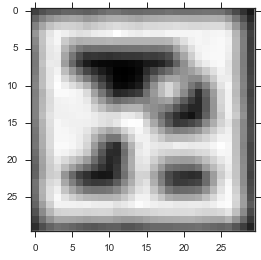

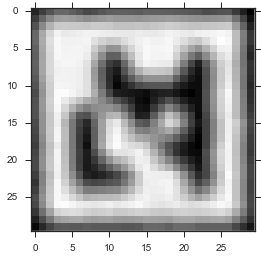

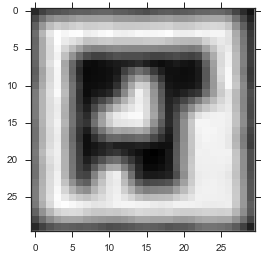

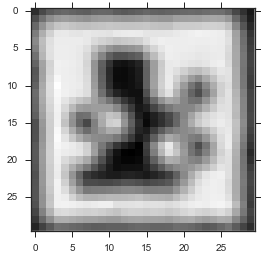

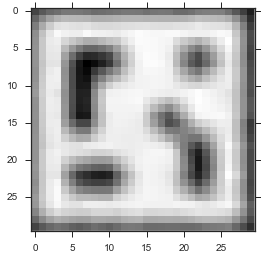

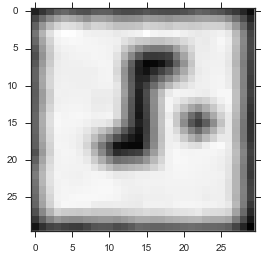

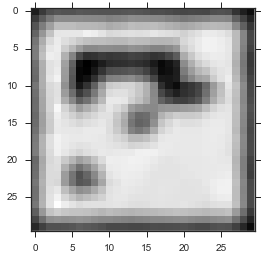

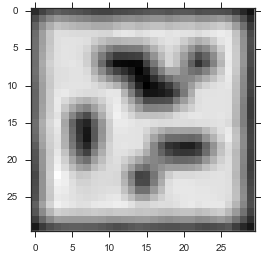

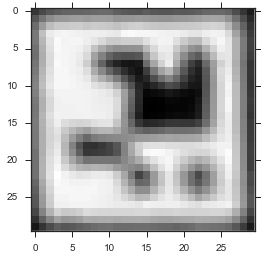

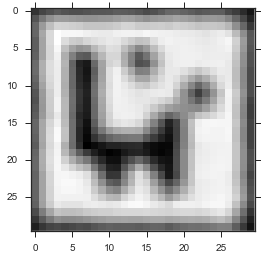

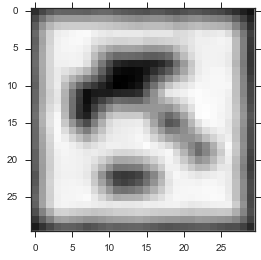

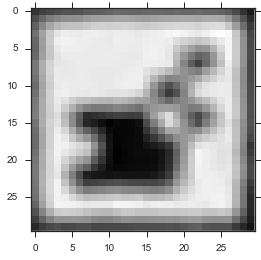

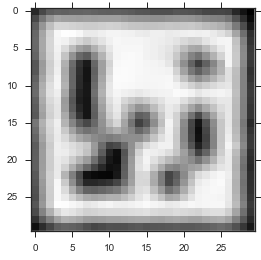

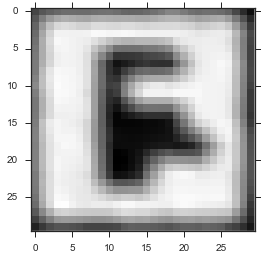

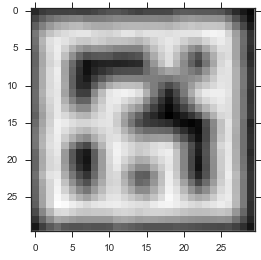

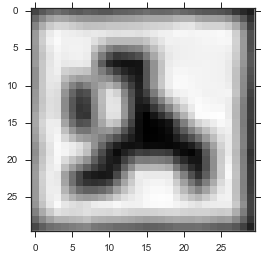

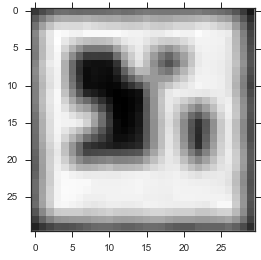

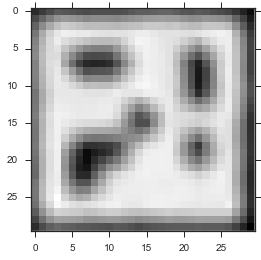

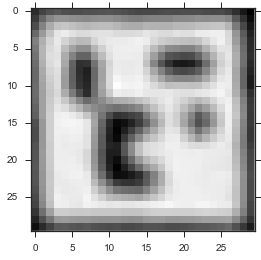

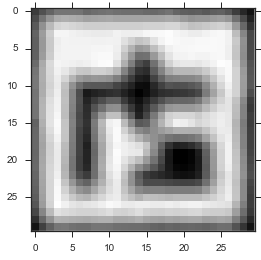

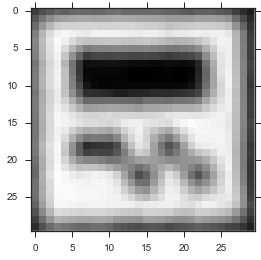

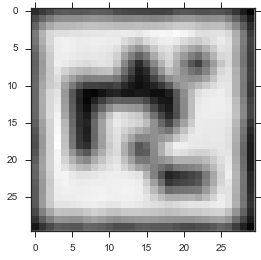

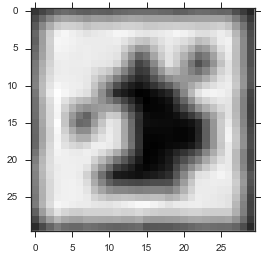

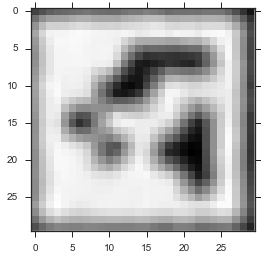

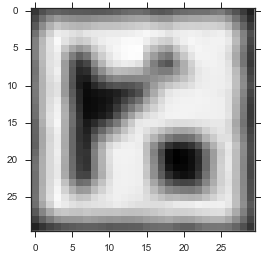

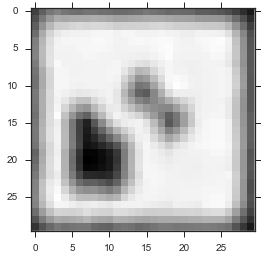

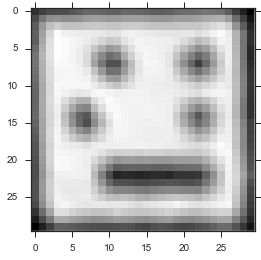

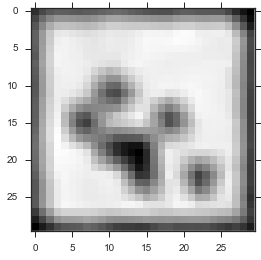

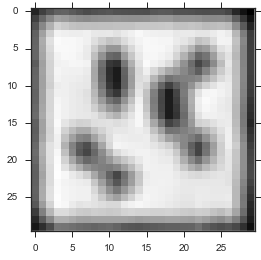

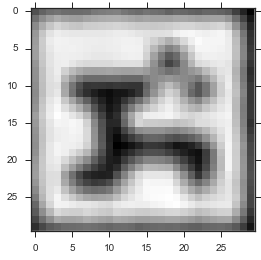

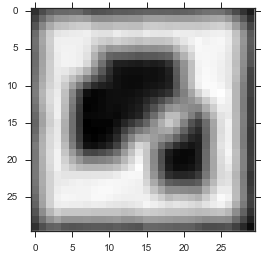

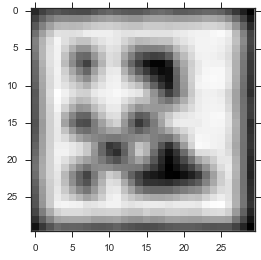

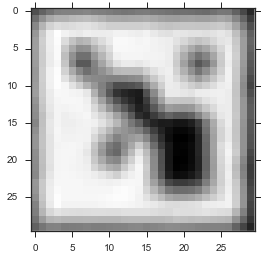

In [161]:
for warped in warped_list:
    plt.imshow(warped, cmap = 'gray', interpolation = 'None')
    plt.show()

In [144]:
pixel_values

array([[ 67,  73,  77, ..., 151, 144, 129],
       [ 88, 106, 119, ..., 175, 172, 158],
       [ 71,  86, 100, ..., 191, 175, 144],
       ..., 
       [ 63,  78,  90, ..., 144, 134, 117],
       [ 51,  59,  68, ..., 173, 162, 145],
       [ 75,  93, 107, ..., 183, 172, 157]], dtype=uint8)

In [145]:
pixel_df = pd.DataFrame(pixel_values)
pixel_df.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,67,73,77,81,86,81,79,77,73,76,...,155,151,152,152,152,150,153,151,144,129
1,88,106,119,128,125,122,119,116,109,102,...,179,177,181,180,178,175,171,175,172,158
2,71,86,100,113,118,117,121,125,121,115,...,179,180,178,184,190,194,196,191,175,144
3,32,57,74,83,84,86,87,88,86,84,...,165,168,162,156,150,145,157,167,162,138
4,34,37,40,43,45,47,48,48,45,49,...,185,182,182,182,182,180,184,184,179,167


In [146]:
master_list = np.load("/Users/Jake/opal/master_list.npy")
master_list

array([[0, 1, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ..., 
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [147]:
def add_border(tag, tag_shape, white_width = 1, black_width = 2):
    
    """Add black and white border to barcode tag.
        
        Parameters
        ----------
        tag : 1-D array_like
            Flattened barcode tag.
        tag_shape : tuple of int
            Shape of the barcode tag without a border.
        white_width : int
            Width of white border.
        black_width : int
            Width of black border.
            
        Returns
        -------
        bordered_tag : 1-D array
            Returns tag with border added flattened to 1-D array.
        """
    
    tag = np.asarray(tag)
    tag = tag.reshape(tag_shape)

    black_border = np.zeros((tag_shape[0]+(2*white_width)+(2*black_width),tag_shape[1]+(2*white_width)+(2*black_width)))
    white_border = np.ones((tag_shape[0]+(2*white_width),tag_shape[1]+(2*white_width)))
    
    white_border[white_width:tag_shape[0]+white_width,white_width:tag_shape[1]+white_width] = tag
    black_border[black_width:tag_shape[0]+(2*white_width)+black_width, black_width:tag_shape[1]+(2*white_width)+black_width] = white_border

    tag = black_border
    bordered_tag = tag.reshape((1,tag.shape[0]*tag.shape[1]))
    tag_shape = black_border.shape
    return  tag_shape, bordered_tag

In [148]:
barcodes = []
for barcode in master_list:
    tag_shape, barcode = add_border(barcode, (5,5), white_width = 1, black_width = 0)
    barcode = barcode.reshape(tag_shape)
    barcode = cv2.resize(barcode, barcode_size, interpolation = cv2.INTER_NEAREST)
    #plt.imshow(barcode, cmap = 'gray', interpolation = 'None')
    #plt.show()
    barcode = barcode.flatten()
    barcodes.append(barcode)
barcodes = np.array(barcodes)
barcodes[barcodes == 0] = 0
barcodes[barcodes == 1] = 255
barcodes.shape


(788, 900)

In [149]:
pixel_values.shape

(150, 900)

In [150]:
n_samples, n_features = pixel_values.shape

# global centering
#barcodes_centered = pixel_values - pixel_values.mean(axis=0)

# local centering
#barcodes_centered -= barcodes_centered.mean(axis=1).reshape(n_samples, -1)

barcodes_centered = pixel_values - pixel_values.mean(axis=1).reshape(n_samples, -1)

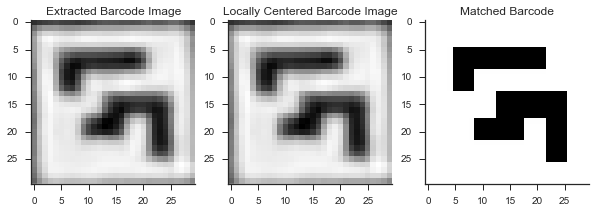

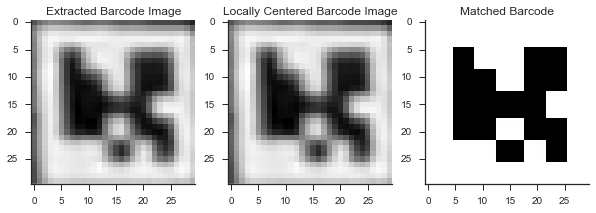

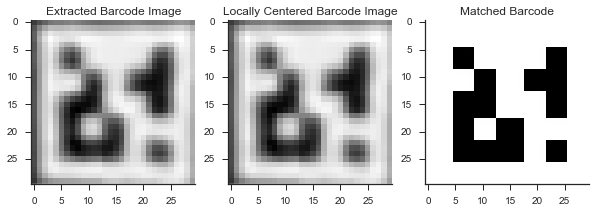

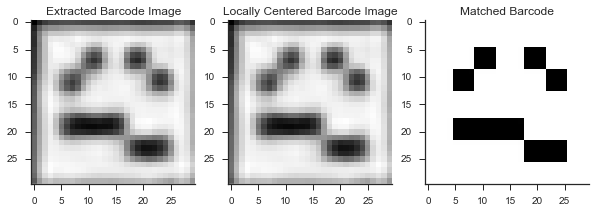

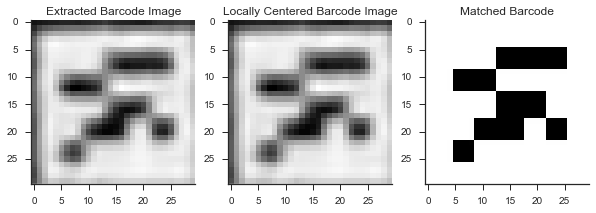

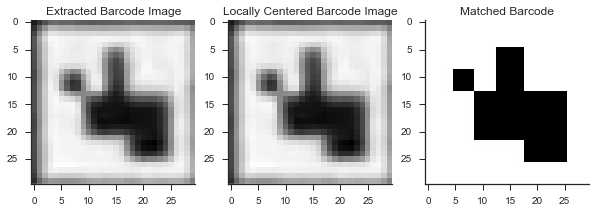

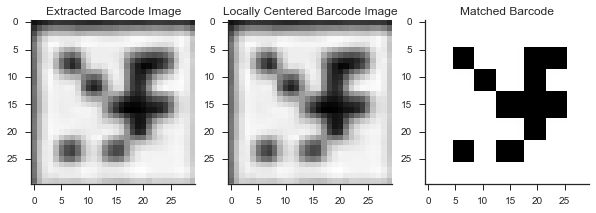

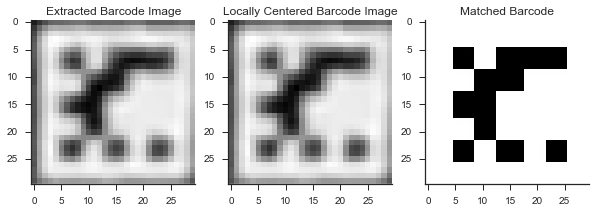

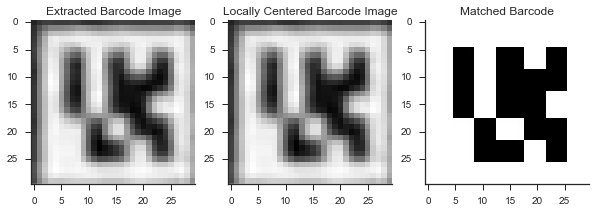

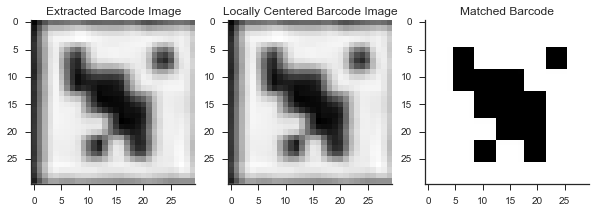

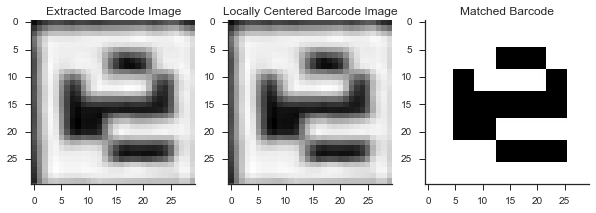

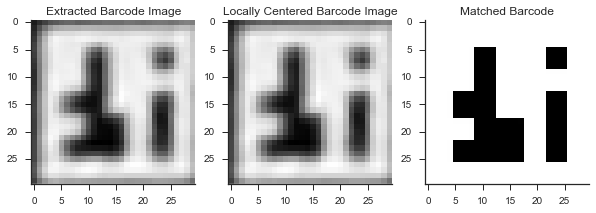

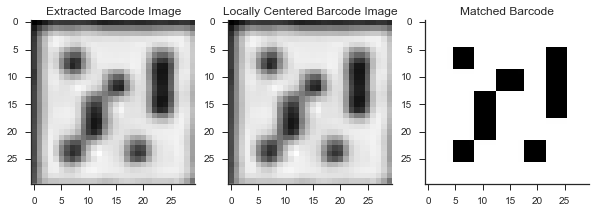

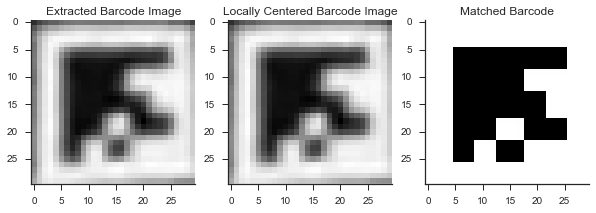

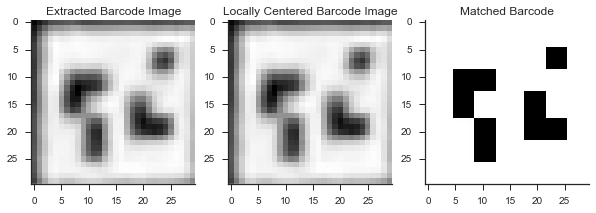

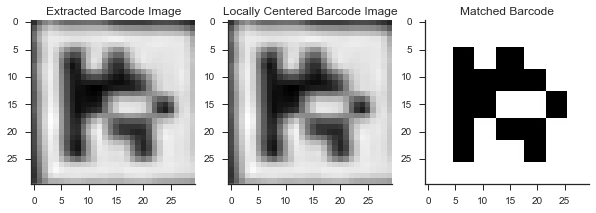

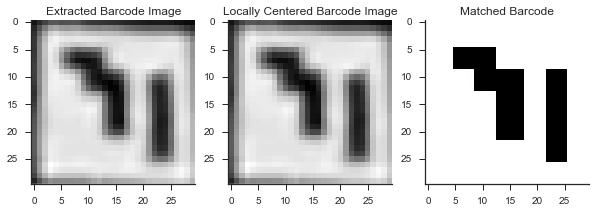

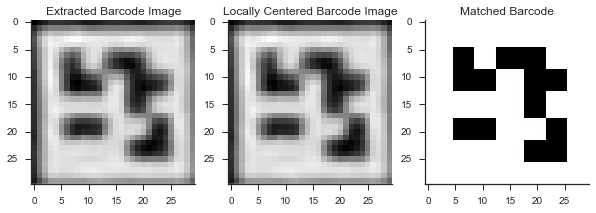

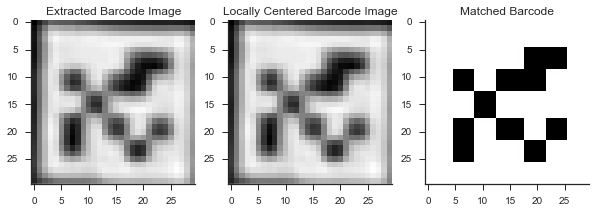

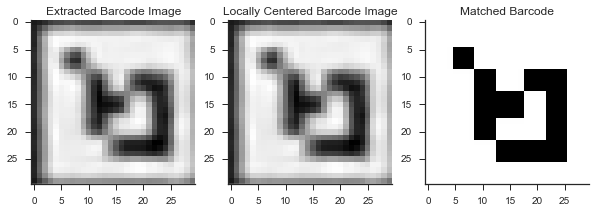

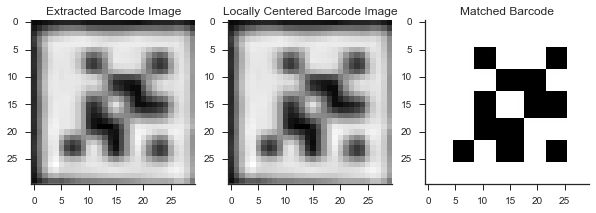

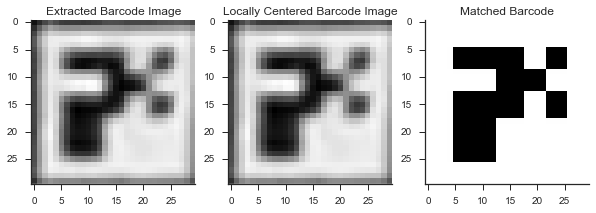

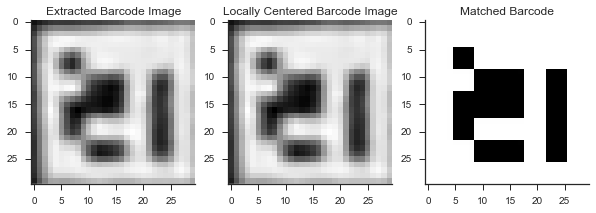

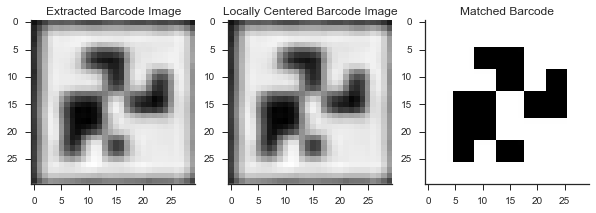

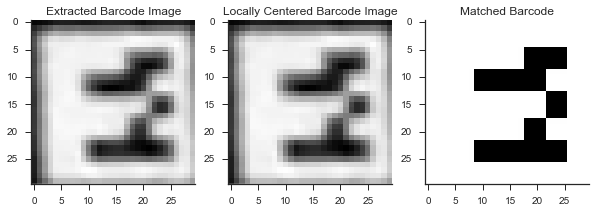

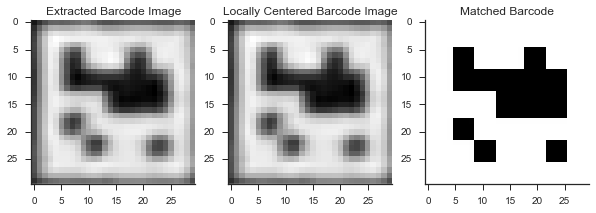

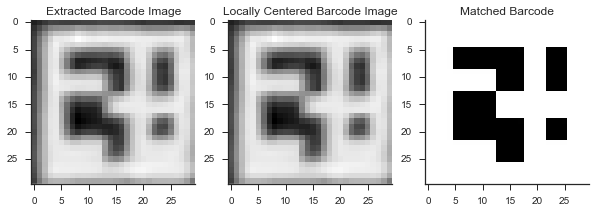

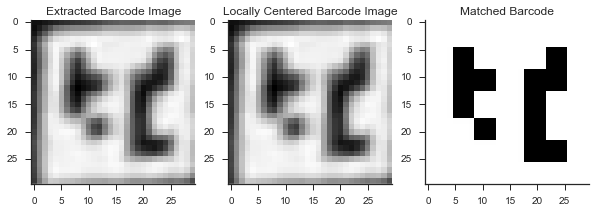

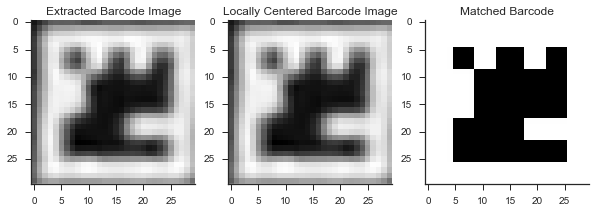

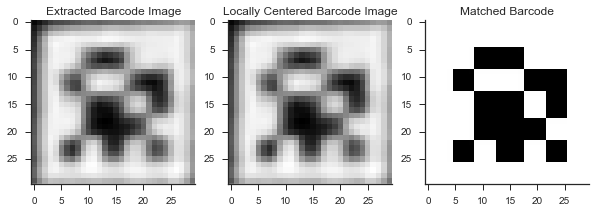

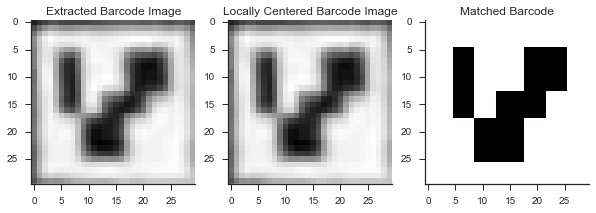

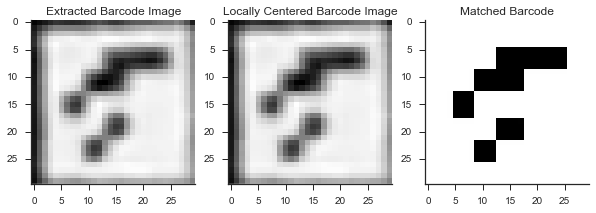

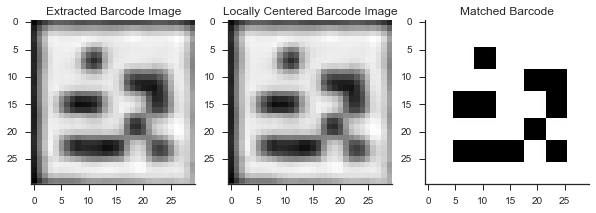

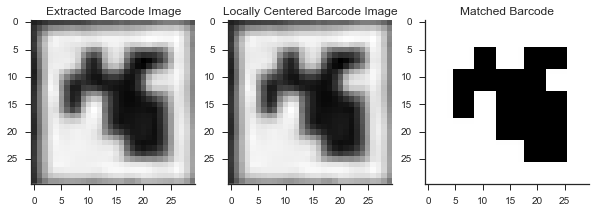

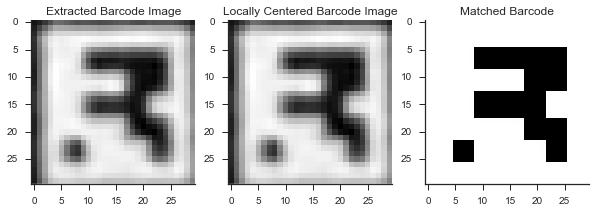

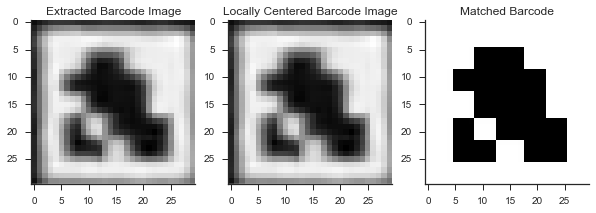

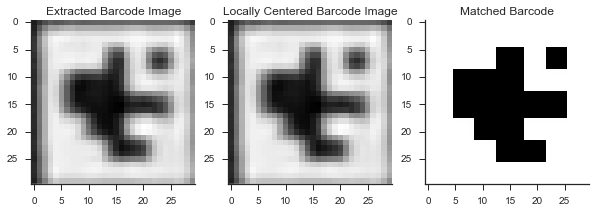

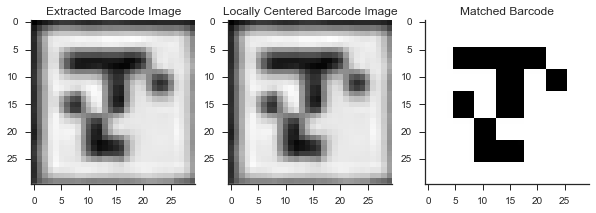

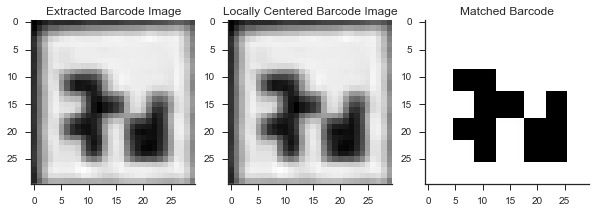

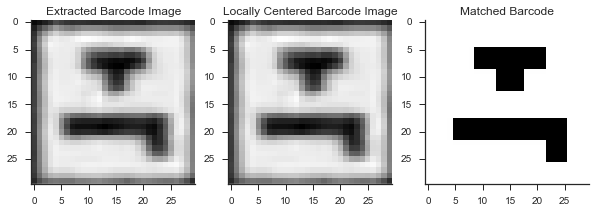

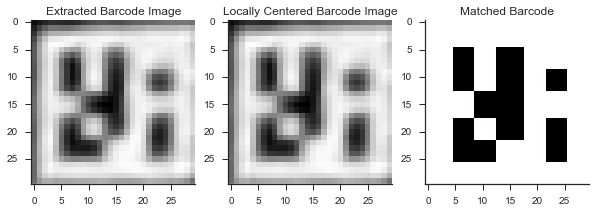

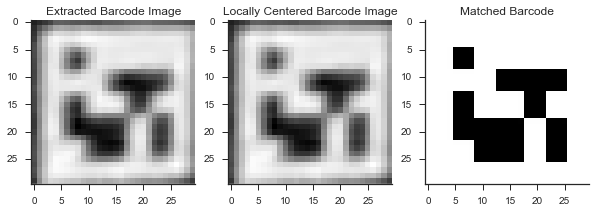

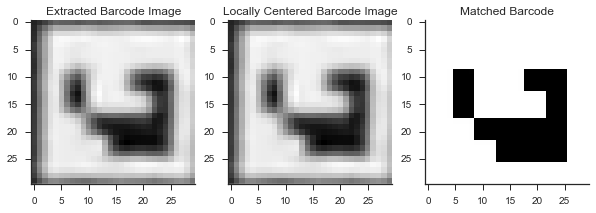

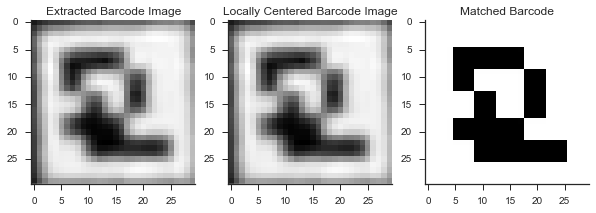

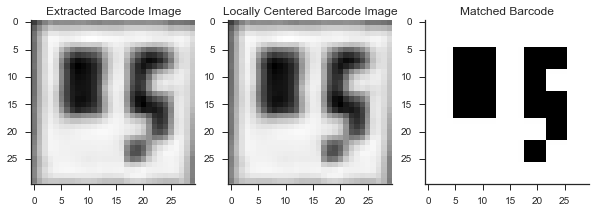

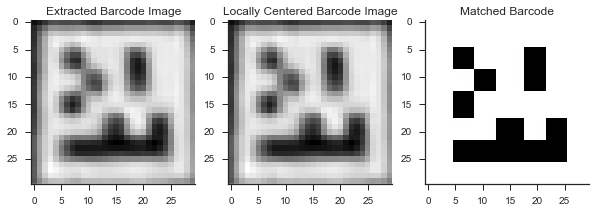

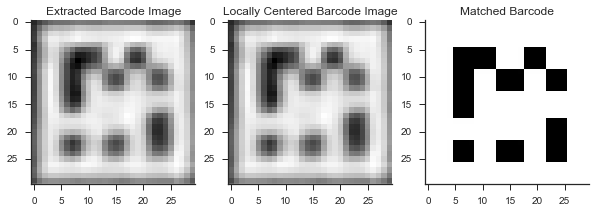

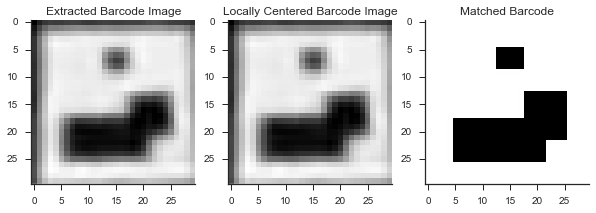

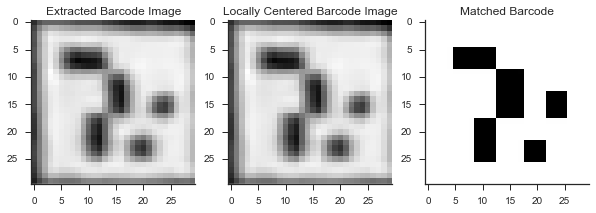

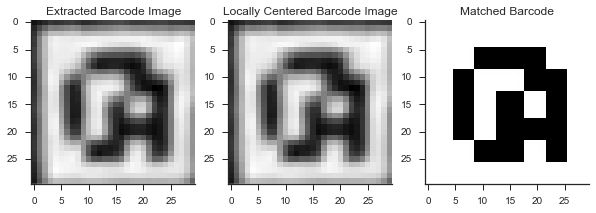

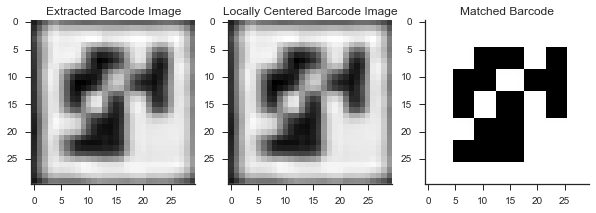

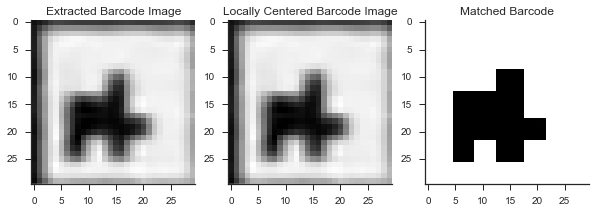

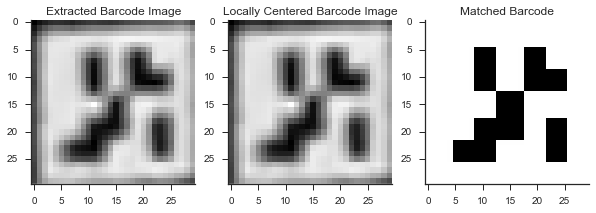

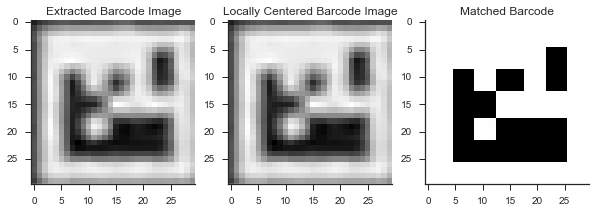

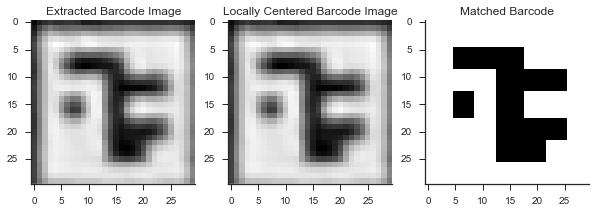

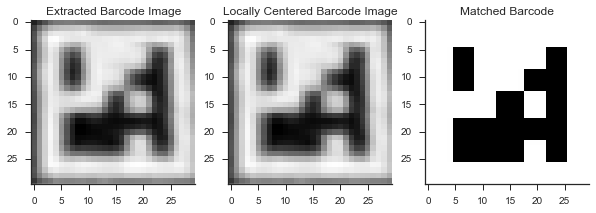

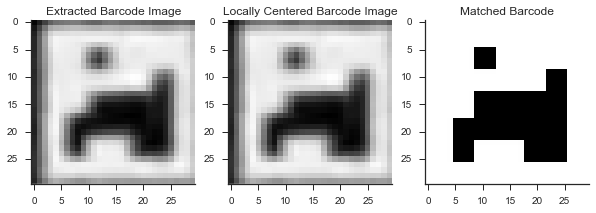

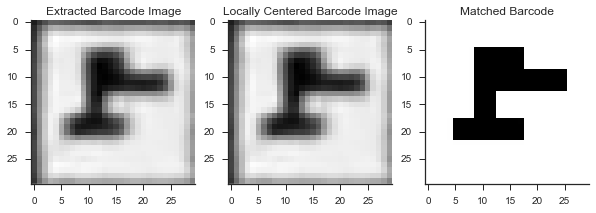

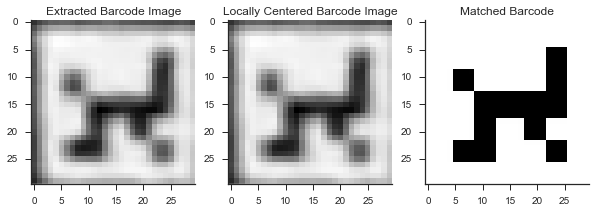

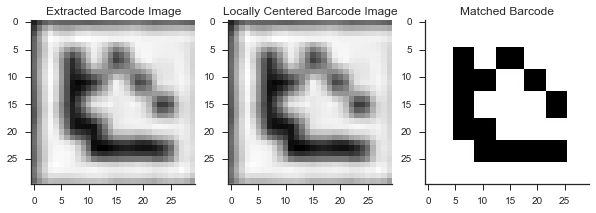

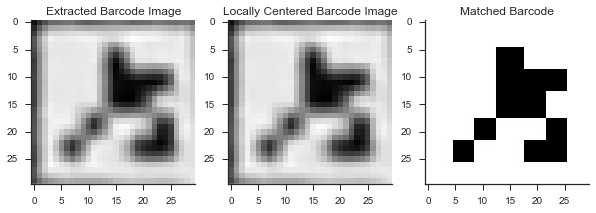

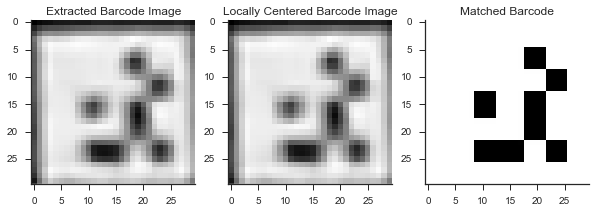

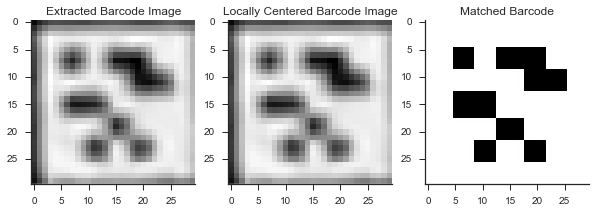

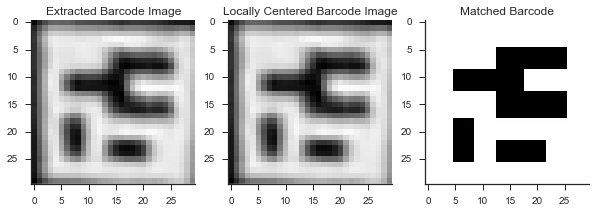

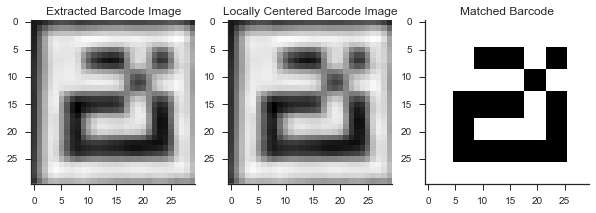

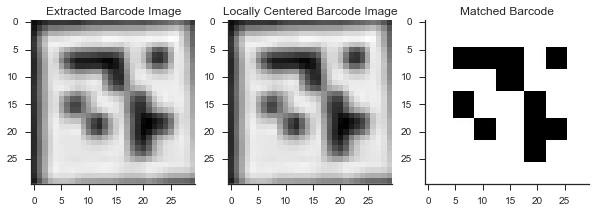

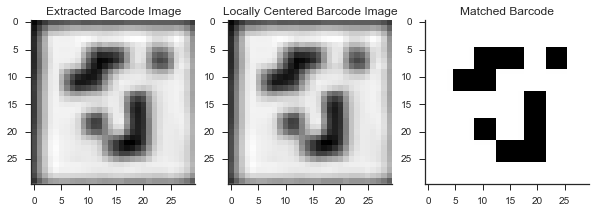

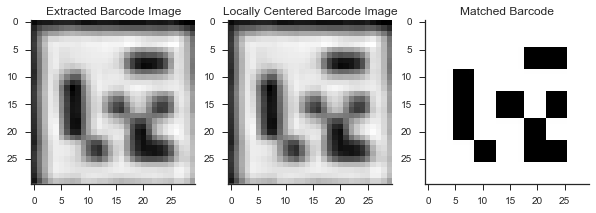

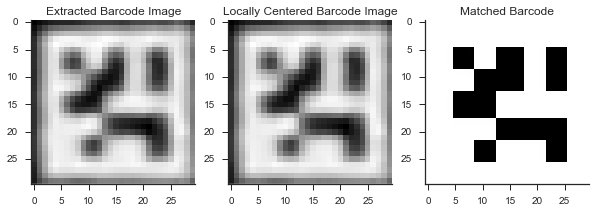

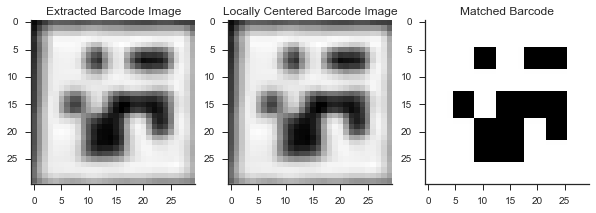

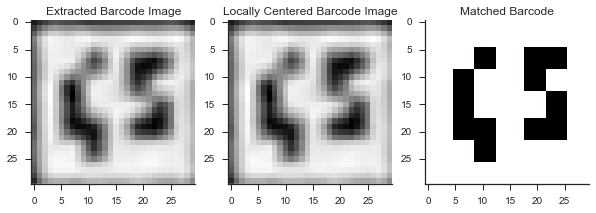

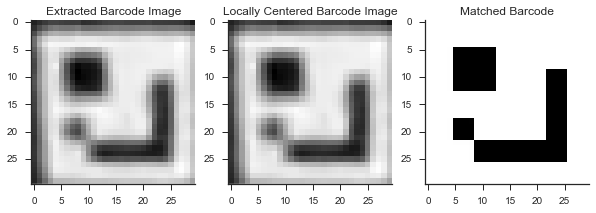

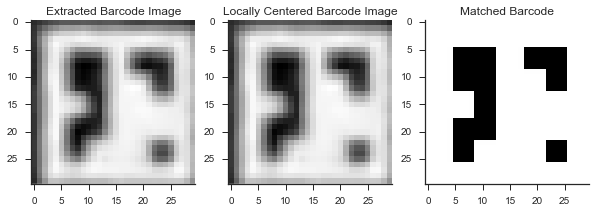

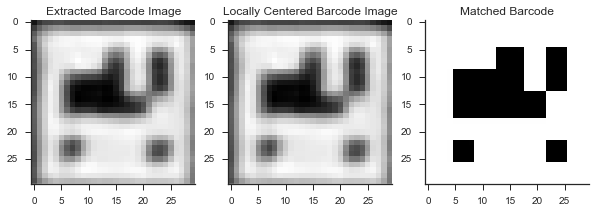

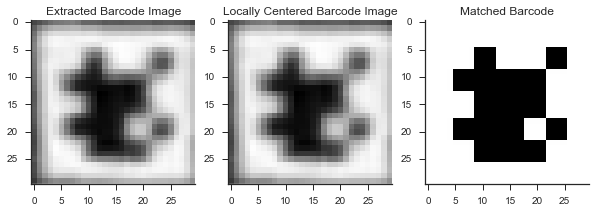

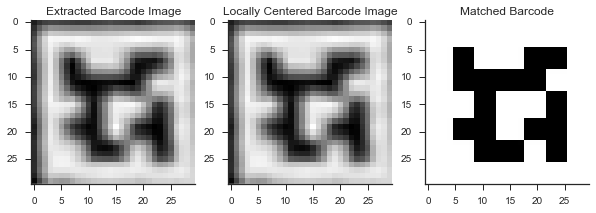

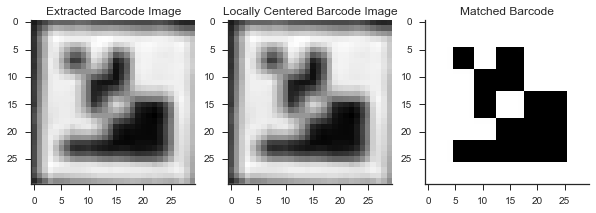

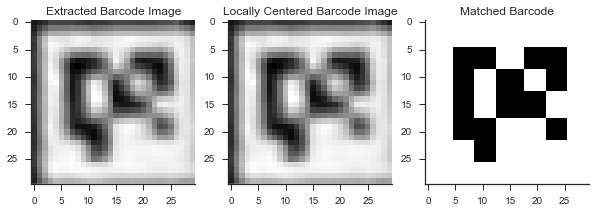

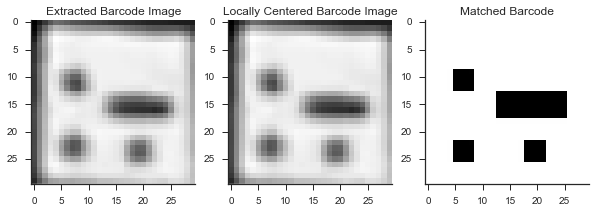

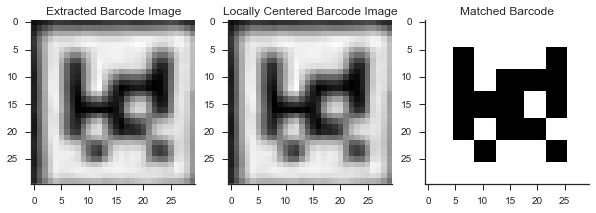

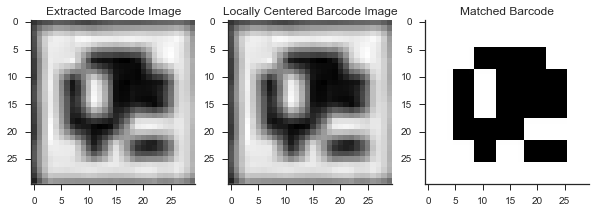

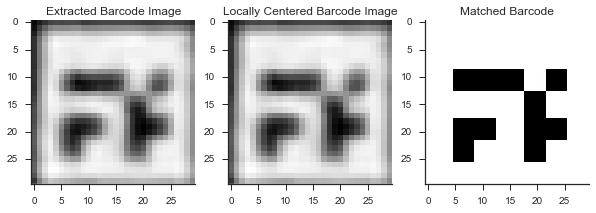

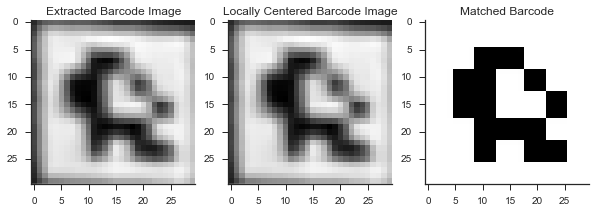

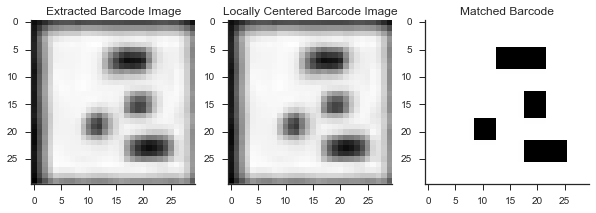

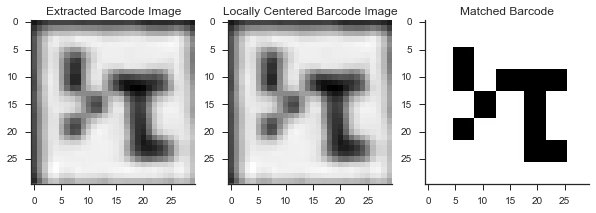

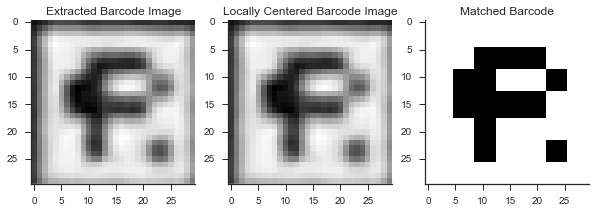

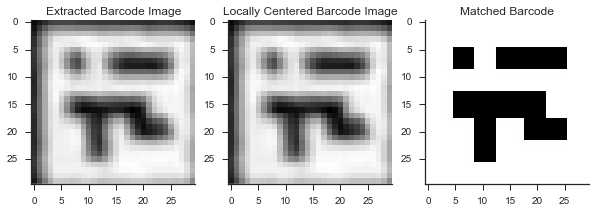

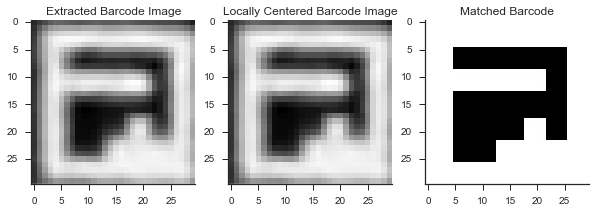

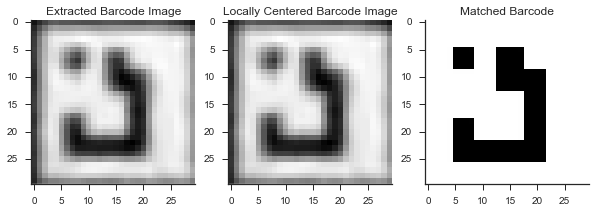

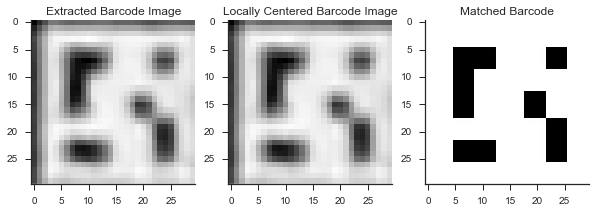

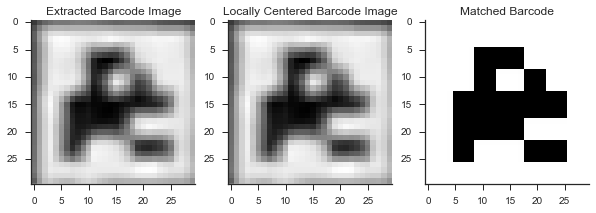

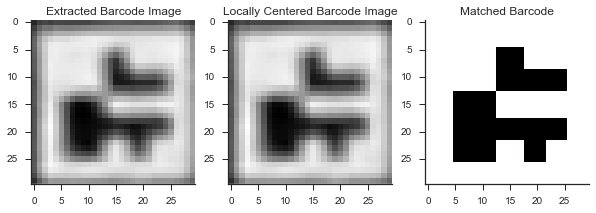

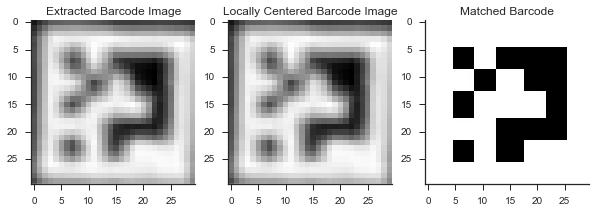

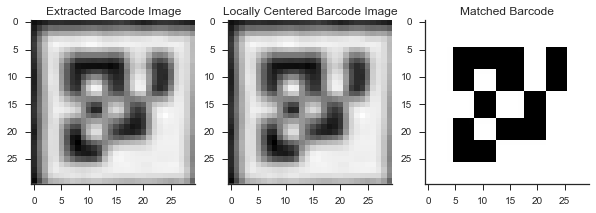

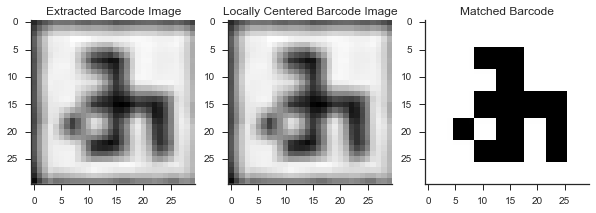

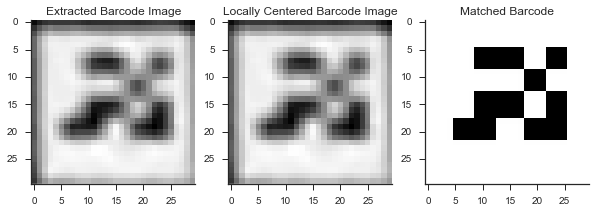

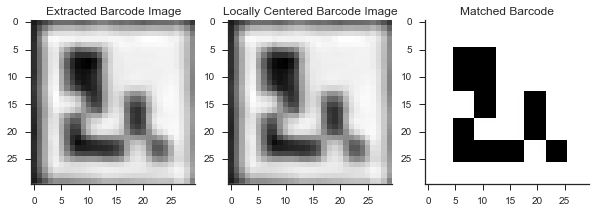

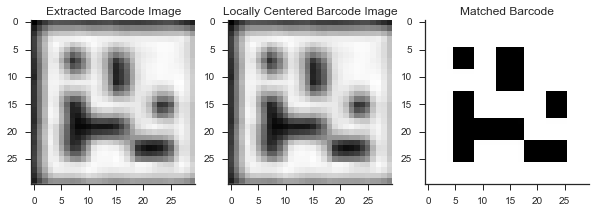

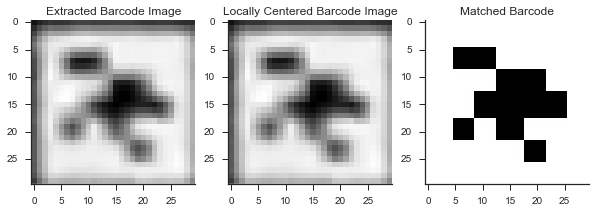

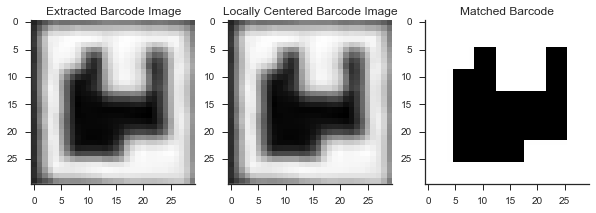

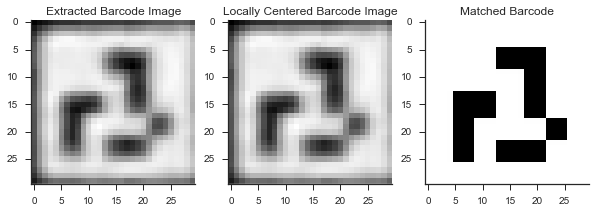

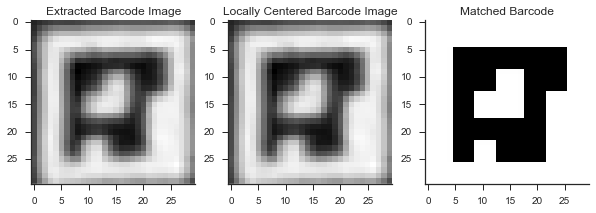

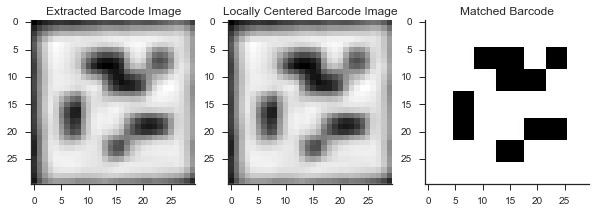

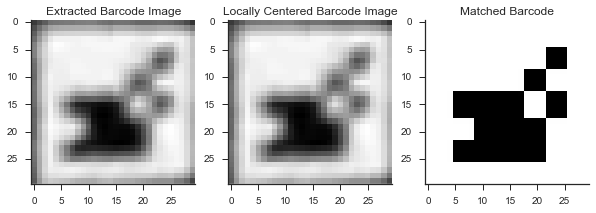

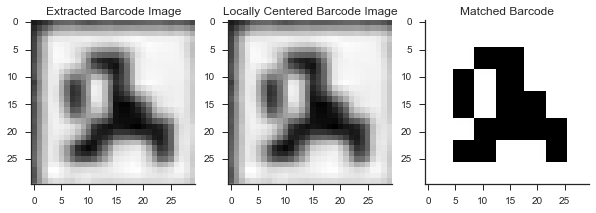

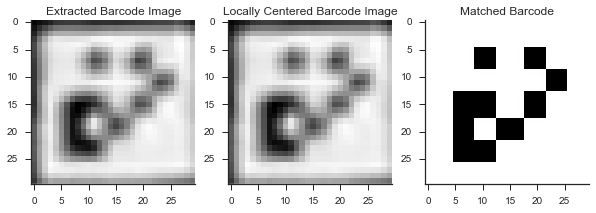

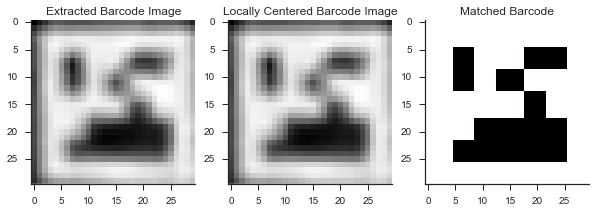

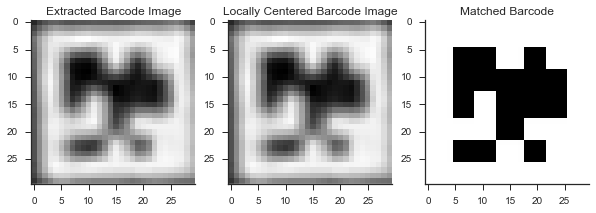

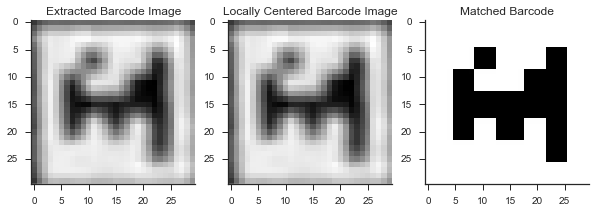

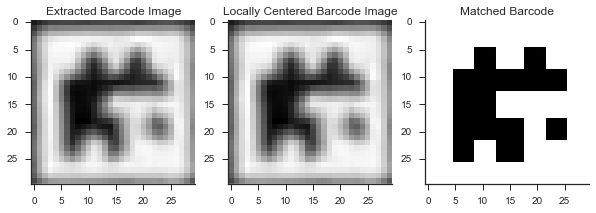

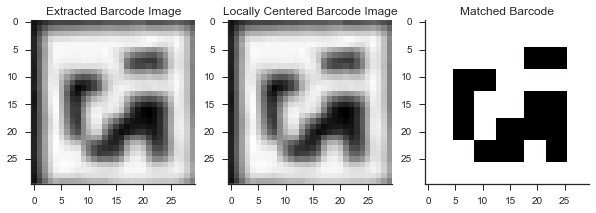

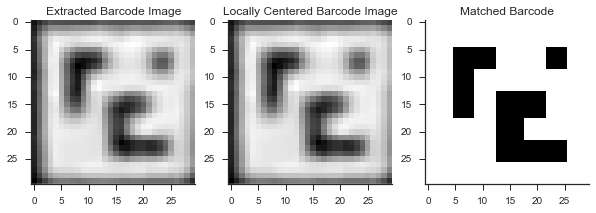

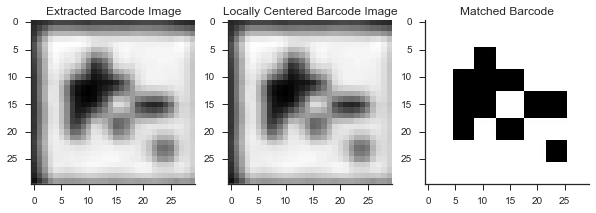

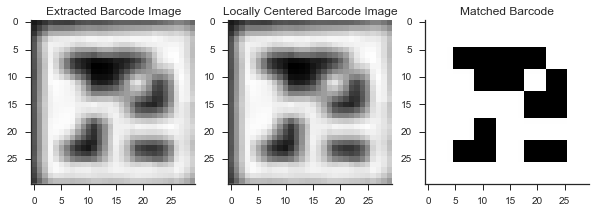

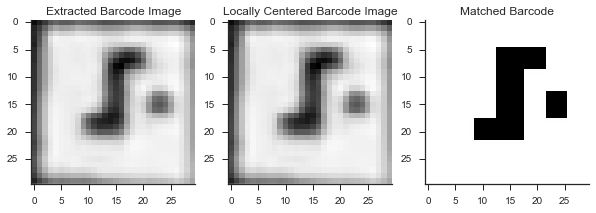

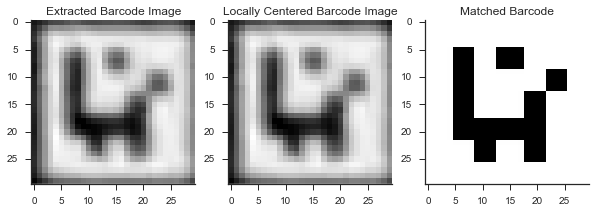

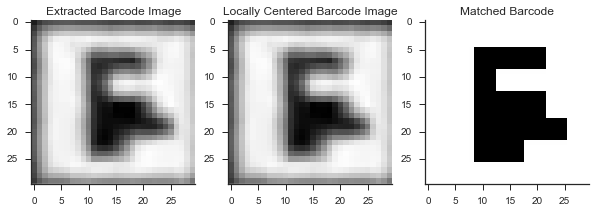

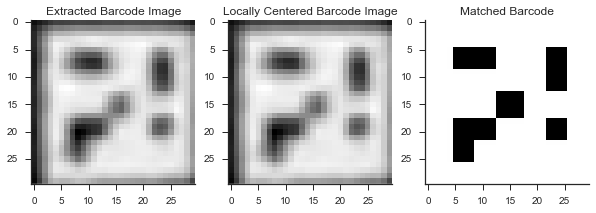

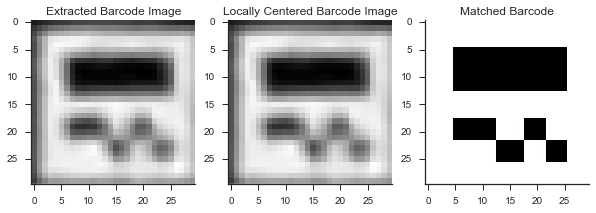

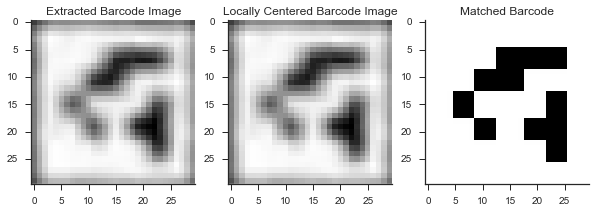

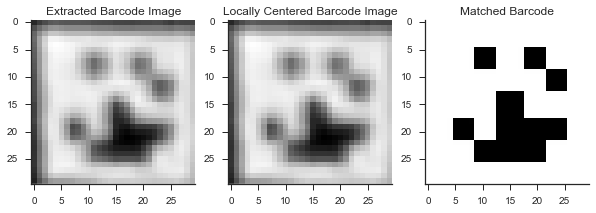

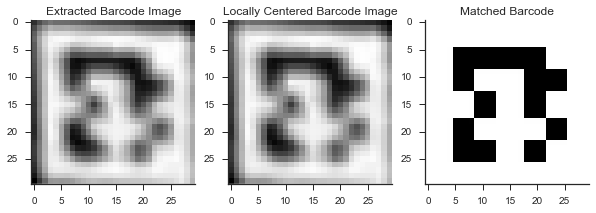

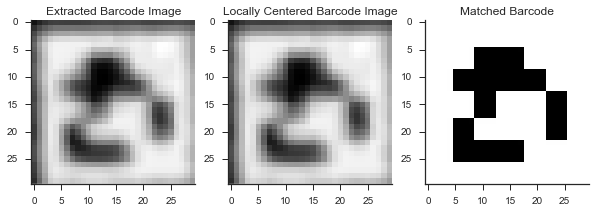

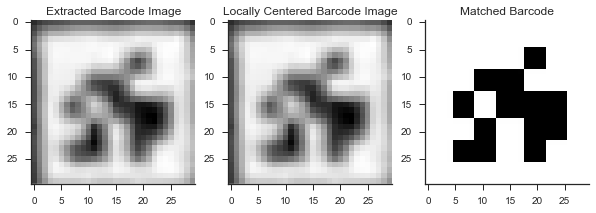

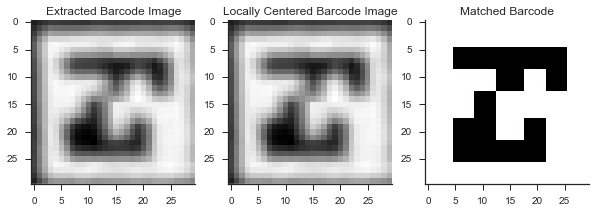

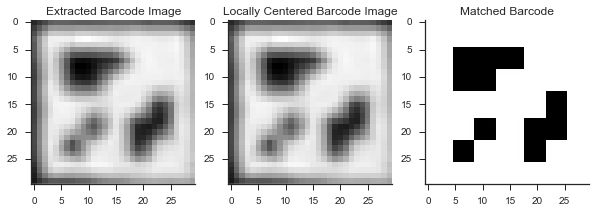

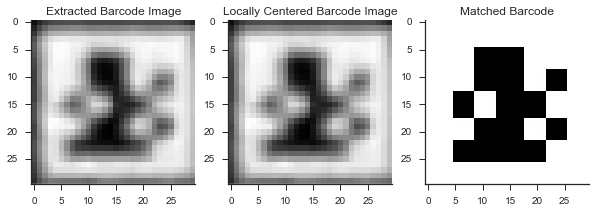

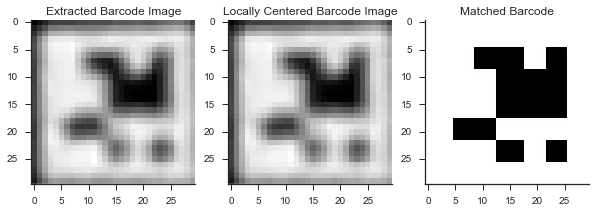

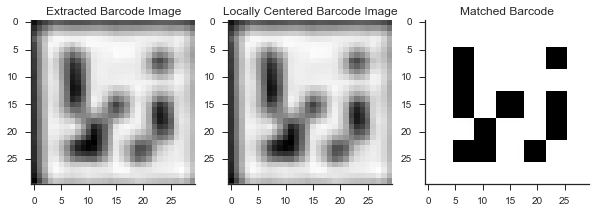

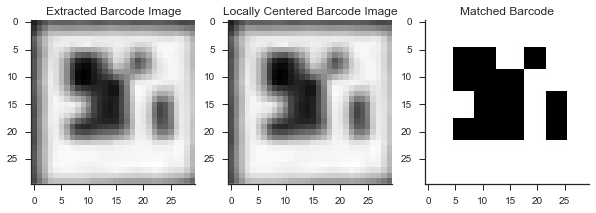

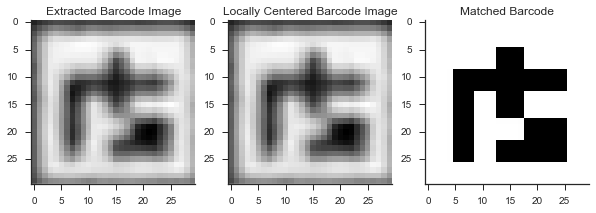

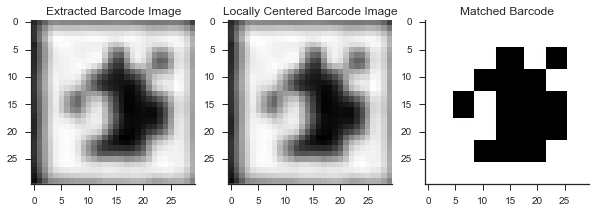

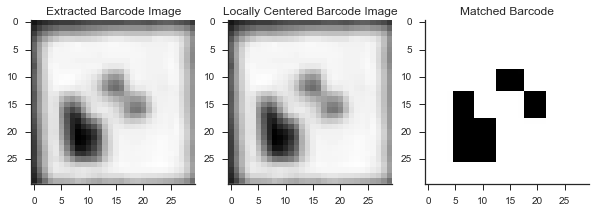

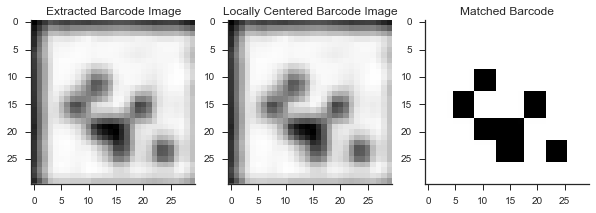

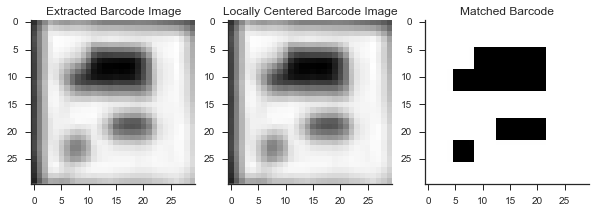

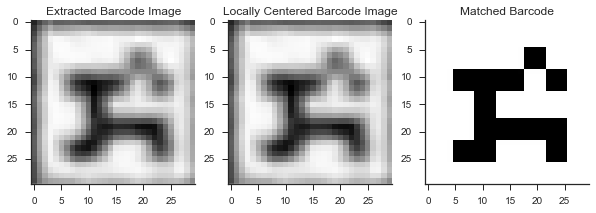

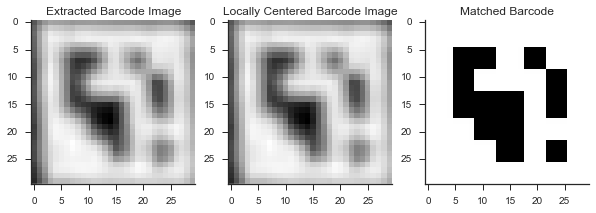

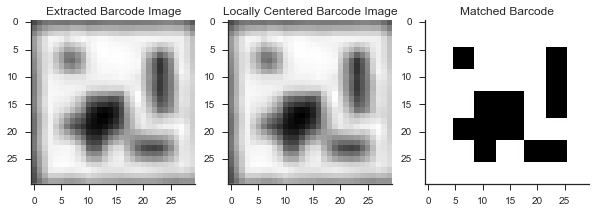

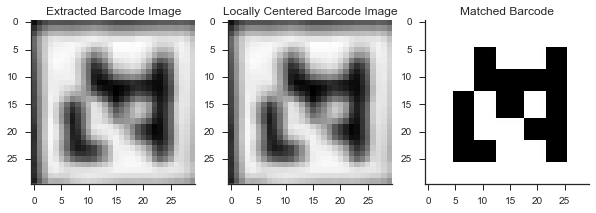

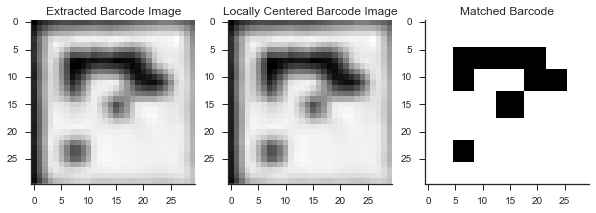

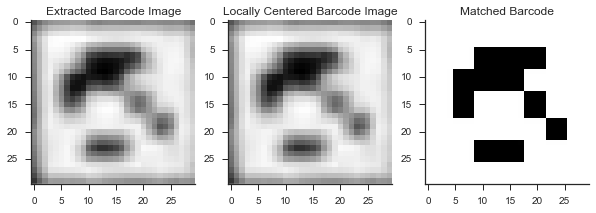

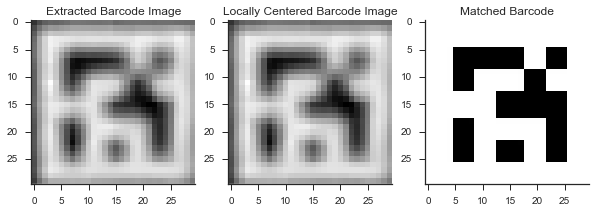

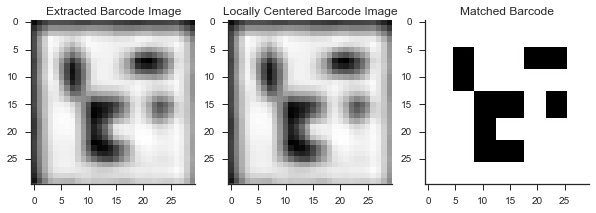

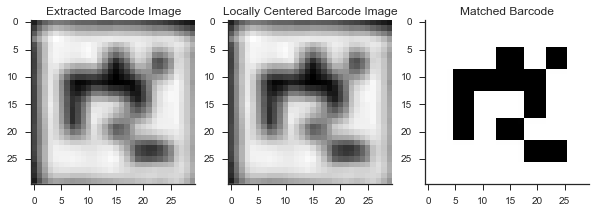

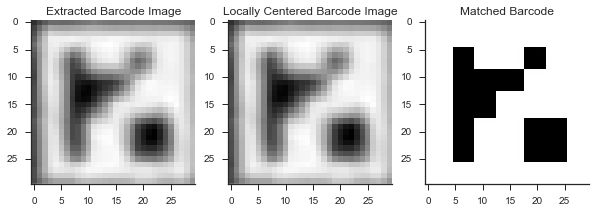

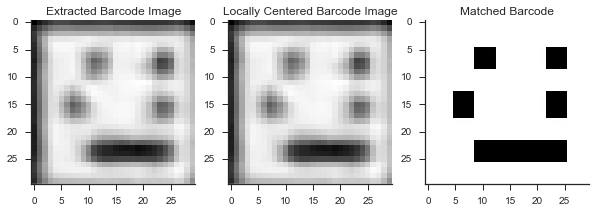

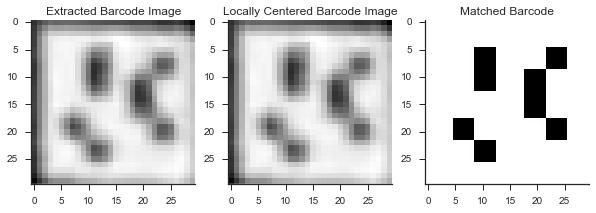

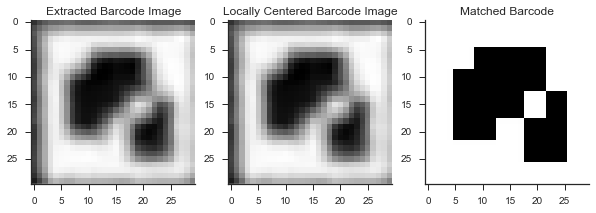

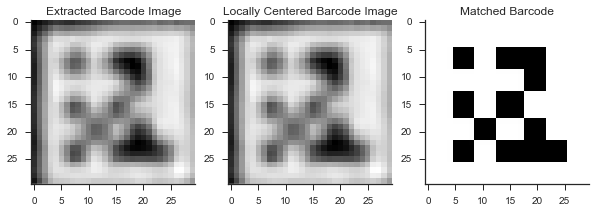

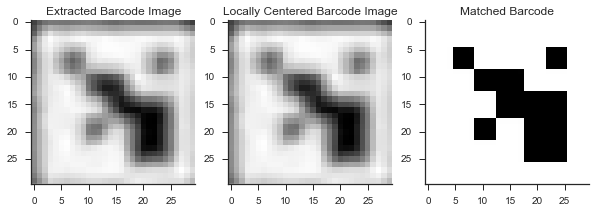

In [151]:
for idx, tag in enumerate(barcodes_centered):
    test = np.repeat([tag], barcodes.shape[0], axis = 0)
    matched = test * barcodes
    #matched = np.abs(matched)
    matched = np.sum(matched, axis = 1)
    test = np.argmax(matched)
    match_tag = barcodes[test].reshape((30,30))
    match_template = pixel_values[idx].reshape((30,30))
    match_template_centered = tag.reshape((30,30))
    cmap = 'gray'
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
    ax1.imshow(match_template, cmap = cmap, interpolation = 'None')
    ax1.set_title("Extracted Barcode Image")
    ax2.imshow(match_template_centered, cmap = cmap, interpolation = 'None')
    ax2.set_title("Locally Centered Barcode Image")
    ax3.imshow(match_tag, cmap = cmap, interpolation = 'None')
    ax3.set_title("Matched Barcode")
    sns.despine(fig)

    plt.show()

In [136]:
match_template_centered

array([[ -6.90622222e+01,  -3.80622222e+01,  -1.30622222e+01,
          5.93777778e+00,   6.93777778e+00,   3.93777778e+00,
          9.37777778e-01,  -6.06222222e+00,  -1.40622222e+01,
         -2.00622222e+01,  -2.50622222e+01,  -2.70622222e+01,
         -2.30622222e+01,  -2.50622222e+01,  -3.10622222e+01,
         -3.60622222e+01,  -3.70622222e+01,  -3.60622222e+01,
         -3.20622222e+01,  -3.40622222e+01,  -3.70622222e+01,
         -4.10622222e+01,  -4.80622222e+01,  -5.00622222e+01,
         -5.20622222e+01,  -5.40622222e+01,  -5.90622222e+01,
         -7.20622222e+01,  -8.40622222e+01,  -9.60622222e+01],
       [ -7.10622222e+01,  -3.10622222e+01,   9.37777778e-01,
          2.49377778e+01,   2.39377778e+01,   2.19377778e+01,
          2.09377778e+01,   1.99377778e+01,   1.59377778e+01,
          1.29377778e+01,   8.93777778e+00,   1.19377778e+01,
          1.19377778e+01,   9.93777778e+00,   5.93777778e+00,
          3.93777778e+00,   9.37777778e-01,   9.37777778e-01,
       

In [86]:
test.shape

(788, 900)

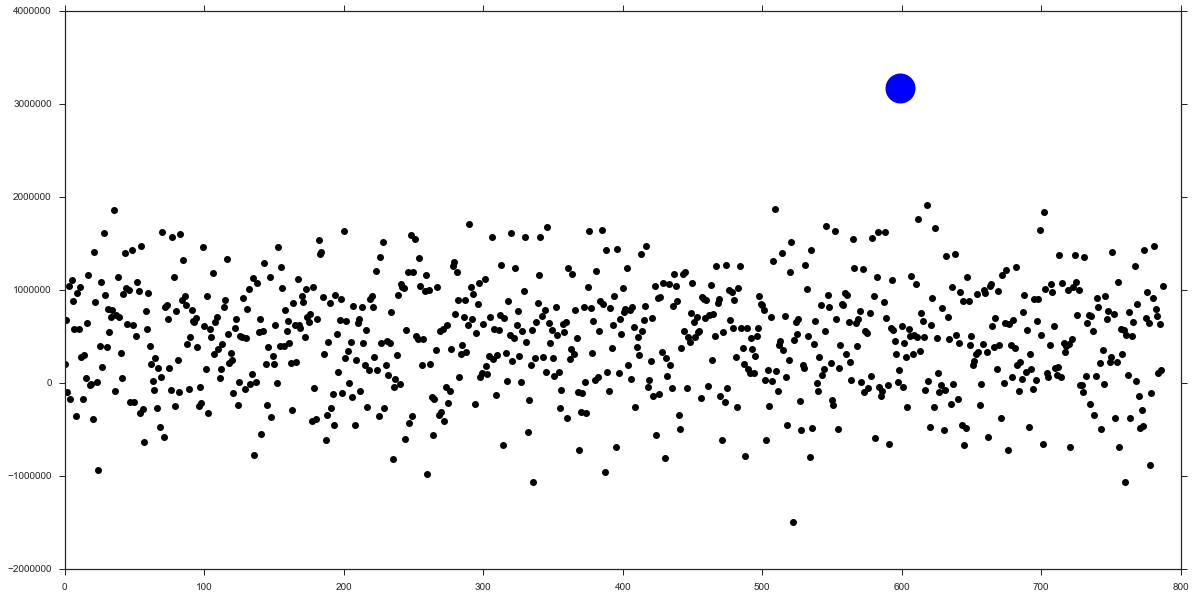

In [99]:
plt.figure(figsize=(20,10))
x = np.arange(0,len(matched))
plt.plot(x, matched, 'ko')
plt.plot(x[test], matched[test], 'bo', ms = 30)
plt.show()

In [100]:
test

599

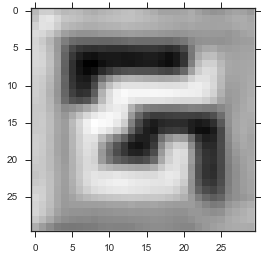

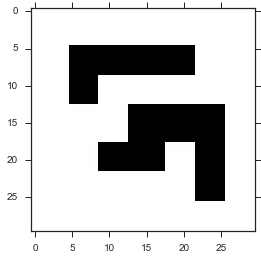

In [101]:
match_tag = barcodes[test].reshape((30,30))
match_template = tag.reshape((30,30))

plt.imshow(match_template, cmap = 'gray', interpolation = 'None')
plt.show()
plt.imshow(match_tag, cmap = 'gray', interpolation = 'None')
plt.show()


In [60]:
match_tag

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255,

In [7]:
import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = barcode_size
rng = RandomState(0)

In [8]:
dataset = pixel_values
faces = dataset

In [9]:
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)



AttributeError: 'list' object has no attribute 'shape'

In [10]:
dataset.shape

AttributeError: 'list' object has no attribute 'shape'

In [11]:
###############################################################################
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

###############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenbarcodes - RandomizedPCA',
     decomposition.RandomizedPCA(n_components=n_components, whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
    
    ('Singular value decomposition components - SVD',
     decomposition.TruncatedSVD(n_components=n_components),
     True)
]


###############################################################################
# Plot a sample of the input data

plot_gallery("First centered barcodes", faces_centered[:n_components])

###############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_
    if hasattr(estimator, 'noise_variance_'):
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

NameError: name 'faces_centered' is not defined